<a href="https://colab.research.google.com/github/faisal-ba-systems/ML-course-documents/blob/main/EDA_Project_Cost_Estimation_Business_Automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.subplots as sp
import seaborn as sns

In [2]:
!pip install -q gdown

# Data 12 month: 01-Sep-2024 to 31-Aug-2025, collection date: 24/08/2025
# https://docs.google.com/spreadsheets/d/13SJ9s2skyqO1vGimtU9RVC7v7T9jwX3B1TpvsA1pHO0/edit?usp=sharing
! gdown 13SJ9s2skyqO1vGimtU9RVC7v7T9jwX3B1TpvsA1pHO0

# Data 18 month: 01-Mar-2024 to 31-Aug-2025, collection date: 24/08/2025
# https://docs.google.com/spreadsheets/d/1f7_sphNw3aAvWJm6MyUmuUwBphN2PwZI32CQk1jj9JA/edit?usp=sharing
# !gdown 1f7_sphNw3aAvWJm6MyUmuUwBphN2PwZI32CQk1jj9JA

Downloading...
From (original): https://drive.google.com/uc?id=13SJ9s2skyqO1vGimtU9RVC7v7T9jwX3B1TpvsA1pHO0
From (redirected): https://docs.google.com/spreadsheets/d/13SJ9s2skyqO1vGimtU9RVC7v7T9jwX3B1TpvsA1pHO0/export?format=xlsx
To: /content/Project Milestone wise log for 12 months 24082025.xlsx
7.19MB [00:00, 124MB/s]


In [3]:
excel_path ='/content/Project Milestone wise log for 12 months 24082025.xlsx'
# excel_path ='/content/Project Milestone wise log for 18 months 24082025.xlsx'
sheet_milestone_resource = 'Milestone Details'
sheet_projects = 'Projects'
sheet_log_hour_against_issue = 'Log Details'
df_milestone_resource = pd.read_excel(excel_path, sheet_name=sheet_milestone_resource)
df_projects = pd.read_excel(excel_path, sheet_name=sheet_projects)
df_log_hour_issue = pd.read_excel(excel_path, sheet_name=sheet_log_hour_against_issue)

In [4]:
def report_data_types_uniques_check(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []

    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())

    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [5]:
# report_data_types_uniques_check(df_projects)
# report_data_types_uniques_check(df_milestone_resource)
# report_data_types_uniques_check(df_log_hour_issue)

### Analysis Dataset

In [6]:
# list(df_projects['type'].unique())
# list(df_projects['status'].unique())

In [7]:
batch_color_discrete_map={
                'complete': 'green',
                'ongoing': 'gold',
                'upcoming': 'lightgreen',
                 }

project_category_color_discrete_map={
                'Commercial': 'green',
                'Non-Commercial': 'blue',
                'Others': 'red'
              }
project_type_color_map = {
    'Service Agreement': '#e74c3c',    # red
    'New Project': '#3498db',          # blue
    'AMC': '#1abc9c',                  # teal
    'Managed Service': '#9b59b6',      # purple
    'RND': '#f1c40f',                  # yellow
    'Internal Project': '#e67e22',     # orange
    'Extend Project': '#2ecc71',       # green
    'Product': '#34495e',              # dark blue/gray
    'Others': '#95a5a6',               # gray
    'New Opportunity': '#d35400',      # dark orange
}

project_status_color_map = {
    'Postponed'      : 'red',
    'Complete'       : 'green',
    'Cancel'         : 'red',
    'Active'         : 'blue',
    'Pause'          : 'orange',  # better differentiate
    'In Progress'    : 'purple',
    'Open'           : 'cyan',
    'Implementation' : 'teal',
    'In Warranty'    : 'lime',
    'Inactive'       : 'gray',
    'Maintenance'    : 'brown',
    'Development'    : 'magenta',  # corrected spelling
    'Unknown'        : 'lightgray'
}


# Section 1 - Analysis Project Overview - Since Start to Current Date

### Clean & Preprocess

In [8]:
# Safe conversion: invalid dates like '0000-00-00' will become NaT
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Calculate duration in days (NaT-safe)
df_projects['duration_days'] = (df_projects['end_dt'] - df_projects['start_dt']).dt.days
df_milestone_resource['duration_days'] = (df_milestone_resource['end_dt'] - df_milestone_resource['start_dt']).dt.days


df_log_hour_issue['start_dt'] = pd.to_datetime(df_log_hour_issue ['start_dt'], errors='coerce')
df_log_hour_issue['end_dt'] = pd.to_datetime(df_log_hour_issue['end_dt'], errors='coerce')

# Calculate duration in days (NaT-safe)
df_log_hour_issue['duration_days'] = (df_log_hour_issue['end_dt'] - df_log_hour_issue['start_dt']).dt.days
df_log_hour_issue['duration_days'] = (df_milestone_resource['end_dt'] - df_milestone_resource['start_dt']).dt.days

# Format as 'YYYY-MM-DD'
df_projects['start_dt'] = df_projects['start_dt'].dt.strftime('%Y-%m-%d')
df_projects['end_dt'] = df_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Fill missing amounts with 0 if necessary
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce').fillna(0)

### Project Overview at a Glance

In [80]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import pandas as pd

# Step 1: Count number of projects per type
type_counts = df_projects['type'].value_counts().reset_index()
type_counts.columns = ['type', 'count']

# Step 2: Sum amount per type
type_amounts = df_projects.groupby('type')['amount'].sum().reset_index()

# Step 3: Merge both into one DataFrame
combined = type_counts.merge(type_amounts, on='type')

# ----- Prepare Table 1: Project Type Summary -----
table1 = combined.copy()
table1['amount'] = table1['amount'].apply(lambda x: f"{x:,.2f} ৳")

# Add Total row to Table 1
total_row_1 = pd.DataFrame({
    'type': ['Total'],
    'count': [table1['count'].sum()],
    'amount': [f"{table1['amount'].str.replace('[৳,]', '', regex=True).astype(float).sum():,.2f} ৳"]
})
table1 = pd.concat([table1, total_row_1], ignore_index=True)

# ----- Prepare Table 2: Project Status Distribution -----
df_projects['status'] = df_projects['status'].fillna('Unknown')
status_counts = df_projects.groupby('status').size().reset_index(name='count')
status_counts['pct'] = (status_counts['count'] / status_counts['count'].sum() * 100).round(2)
status_counts['pct'] = status_counts['pct'].apply(lambda x: f"{x:.2f}%")

# Add Total row to Table 2
total_row_2 = pd.DataFrame({
    'status': ['Total'],
    'count': [status_counts['count'].astype(int).sum()],
    'pct': ['100.00%']
})
status_counts = pd.concat([status_counts, total_row_2], ignore_index=True)

# ----- Create Subplot: Two Tables Side-by-Side -----
fig_tables = make_subplots(
    rows=1, cols=2,
    subplot_titles=("<b>Project Count and Budget by Type</b>", "<b>Project Status Distribution</b>"),
    specs=[[{"type": "table"}, {"type": "table"}]]
)

# Add Table 1
fig_tables.add_trace(
    go.Table(
        header=dict(
            values=["<b>Project Type</b>", "<b>Number of Projects</b>", "<b>Total Budget</b>"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=16),
            height=35
        ),
        cells=dict(
            values=[table1['type'], table1['count'], table1['amount']],
            fill_color='white',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=14),
            height=30
        )
    ),
    row=1, col=1
)

# Add Table 2
fig_tables.add_trace(
    go.Table(
        header=dict(
            values=["<b>Status</b>", "<b>Number of Projects</b>", "<b>Percentage</b>"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=16),
            height=35
        ),
        cells=dict(
            values=[status_counts['status'], status_counts['count'], status_counts['pct']],
            fill_color='white',
            align='center',
            line_color='black',
            line_width=2,
            font=dict(size=14),
            height=30
        )
    ),
    row=1, col=2
)

# Add caption
fig_tables.update_layout(
    title=dict(
        text=" <b>Project Overview at a Glance</b> <br>From Starting to Till Now",
        x=0.5,
        xanchor='center',
        pad=dict(b=50),
        font=dict(size=25)
    ),
    height=800,
    margin=dict(t=200, b=100),
)

# ---- Show the tables ----
fig_tables.show()


In [81]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Define color list for bar chart and pie chart ---
bar_colors = combined['type'].map(project_type_color_map)
pie_colors = combined['type'].map(project_type_color_map)

# --- Bar chart trace ---
bar_trace = go.Bar(
    x=combined['type'],
    y=combined['count'],
    text=combined['count'],
    textposition='auto',
    marker_color=bar_colors,  # ✅ use color map
    hovertemplate=(
        "Project Type: %{x}<br>" +
        "Number of Projects: %{y}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    ),
    customdata=combined[['amount']].values,
    showlegend=False
)

# --- Pie chart trace ---
pie_trace = go.Pie(
    labels=combined['type'],
    values=combined['count'],
    hovertemplate=(
        "<b>%{label}</b><br>" +
        "Number of Projects: %{value}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    ),
    textinfo='percent',
    customdata=combined[['amount']].values,
    marker_colors=pie_colors,  # ✅ same color map
    showlegend=True
)

# --- Subplots ---
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    specs=[[{"type": "bar"}, {"type": "domain"}]],
    subplot_titles=("Project Count by Type", "Project Count Share")
)

# Add traces
fig.add_trace(bar_trace, row=1, col=1)
fig.add_trace(pie_trace, row=1, col=2)

# Layout
fig.update_layout(
    title="Chart 1: Project Count and Budget by Type",
    title_x=0.5,
    xaxis=dict(title="Project Type", tickangle=45),
    yaxis=dict(title="Number of Projects"),
    height=500
)

fig.show()

import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Fill missing status and prepare counts ---
df_projects['status'] = df_projects['status'].fillna('Unknown')

# Group by status
status_counts = df_projects.groupby('status').agg(
    count=('status', 'size'),
    amount=('amount', 'sum')  # assuming you have a 'budget' column
).reset_index().sort_values(by='count', ascending=False)

# Percentage column
status_counts['pct'] = (status_counts['count'] / status_counts['count'].sum() * 100).round(2)
status_counts['pct'] = status_counts['pct'].apply(lambda x: f"{x:.2f}%")

# --- Optional: Add Total row for table only ---
total_row_2 = pd.DataFrame({
    'status': ['Total'],
    'count': [status_counts['count'].sum()],
    'amount': [status_counts['amount'].sum()],
    'pct': ['100.00%']
})
status_table = pd.concat([status_counts, total_row_2], ignore_index=True)

# --- Use only real statuses (exclude 'Total') for charts ---
chart_data = status_counts.copy()

# Map colors
colors = [project_status_color_map.get(s, 'black') for s in chart_data['status']]

# --- Bar chart trace ---
bar_trace = go.Bar(
    x=chart_data['status'],
    y=chart_data['count'],
    text=chart_data['count'],
    textposition='auto',
    marker_color=colors,
    hovertemplate=(
        "Status: %{x}<br>" +
        "Number of Projects: %{y}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    ),
    customdata=chart_data[['amount']].values,
    showlegend=False
)

# --- Pie chart trace ---
pie_trace = go.Pie(
    labels=chart_data['status'],
    values=chart_data['count'],
    marker_colors=colors,
    hovertemplate=(
        "<b>%{label}</b><br>" +
        "Number of Projects: %{value}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    ),
    textinfo='percent',
    customdata=chart_data[['amount']].values,
    showlegend=True
)

# --- Subplots ---
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.6, 0.4],
    specs=[[{"type": "bar"}, {"type": "domain"}]],
    subplot_titles=("Project Status Count", "Project Status Share")
)

fig.add_trace(bar_trace, row=1, col=1)
fig.add_trace(pie_trace, row=1, col=2)

# --- Layout ---
fig.update_layout(
    title="Chart 2: Project Status Overview",
    title_x=0.5,
    xaxis=dict(title="Project Status", tickangle=45),
    yaxis=dict(title="Number of Projects"),
    height=500
)

fig.show()

### Top 10 Project Budgets by Status

In [77]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['status', 'caption', 'amount', 'ref_no'])

# Get unique project statuses
project_statuses = df_projects['status'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, status in enumerate(project_statuses):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['status'] == status]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # highest bar on top
    )

    # Assign colors based on status
    bar_colors = [project_status_color_map.get(s, 'black') for s in df_filtered['status']]

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['ref_no'],
        orientation='h',
        name=status,
        marker=dict(
            color=bar_colors  # ✅ use your status color map
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['caption','status','start_dt','end_dt','type']],
        hovertemplate=(
            "Project Name: %{y}<br>" +
            "Project Caption: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Project Type: %{customdata[4]}<br>" +
            "Amount: %{x:,.2f} ৳<extra></extra>"
        )
    ))

    # Set visibility for dropdown
    visibility = [False] * len(project_statuses)
    visibility[i] = True

    buttons.append(dict(
        label=f"{status} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 3: Project Status - <b>{status}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 3: Project Status - <b>{project_statuses[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount (৳)",
    yaxis_title="Project Name",
    showlegend=False,
    height=600
)

fig.show()


### Top 10 Longest Running Projects (Duration from Start to End Date)

In [79]:
import plotly.express as px
import pandas as pd

# Ensure datetime
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Format duration (e.g. 1 year 2 months 3 days)
def format_duration(days):
    if pd.isna(days):
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

df_projects['duration_days'] = pd.to_numeric(df_projects['duration_days'], errors='coerce')
df_projects['duration timeline'] = df_projects['duration_days'].apply(format_duration)

# Format dates as strings
df_projects['start_dt_str'] = df_projects['start_dt'].dt.strftime('%Y-%m-%d')
df_projects['end_dt_str'] = df_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 20 by duration
top_duration = df_projects.sort_values('duration_days', ascending=False).head(20)

# Plot
fig = px.bar(
    top_duration,
    x='duration_days',
    y='ref_no',
    color='duration_days',
    color_continuous_scale='RdYlGn_r',
    title='Chart 4: Top 10 Longest Running Projects (From Starting to Till Now)',
    text='duration timeline',
    labels={
        'caption': 'Project Caption',
        'ref_no': 'Project Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Formatted Duration',
        'amount': 'Project Amount',
        'start_dt_str': 'Start Date',
        'end_dt_str': 'End Date',
        'status': 'Project Status',
        'type': 'Project Type'
    },
    hover_data=['ref_no','caption','amount', 'duration_days', 'duration timeline', 'start_dt_str', 'end_dt_str','status', 'type']
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Days)',
    title_x=0.5,
    yaxis_title='Project Name',
    xaxis_tickangle=0,
    height=800,
    showlegend=False
)

fig.show()


### Number of Projects by Year (Start Year, Go-Live Year, End Year)

In [82]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# Assume df_projects is your DataFrame

# Process data for start year
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['start_year'] = df_projects['start_dt'].dt.year
start_year_counts = (
    df_projects['start_year']
    .value_counts()
    .sort_index()
    .reset_index()
)
start_year_counts.columns = ['Year', 'Project Count']

# Process data for go-live year
df_projects['go_live_date'] = pd.to_datetime(df_projects['go_live_date'], errors='coerce')
df_projects['go_live_year'] = df_projects['go_live_date'].dt.year
go_live_year_counts = (
    df_projects['go_live_year']
    .value_counts()
    .sort_index()
    .reset_index()
)
go_live_year_counts.columns = ['Year', 'Project Count']

# Process data for end year
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')
df_projects['end_year'] = df_projects['end_dt'].dt.year
end_year_counts = (
    df_projects['end_year']
    .value_counts()
    .sort_index()
    .reset_index()
)
end_year_counts.columns = ['Year', 'Project Count']

# Create the bar traces with continuous color
trace1 = px.bar(
    start_year_counts,
    x='Year',
    y='Project Count',
    color='Project Count',
    color_continuous_scale='RdYlGn',
    text='Project Count'
).data[0]

trace2 = px.bar(
    go_live_year_counts,
    x='Year',
    y='Project Count',
    color='Project Count',
    color_continuous_scale='RdYlGn',
    text='Project Count'
).data[0]

trace3 = px.bar(
    end_year_counts,
    x='Year',
    y='Project Count',
    color='Project Count',
    color_continuous_scale='RdYlGn',
    text='Project Count'
).data[0]

# Assign separate coloraxes to each trace for independent color scaling
trace1.marker.coloraxis = 'coloraxis'
trace2.marker.coloraxis = 'coloraxis2'
trace3.marker.coloraxis = 'coloraxis3'

# Create subplots: 3 rows, 1 column
fig = make_subplots(
    rows=3,
    cols=1,
    subplot_titles=(
        'Number of Projects by Start Year',
        'Number of Projects by Go-Live Year',
        'Number of Projects by End Year'
    ),
    vertical_spacing=0.1
)

# Add traces to subplots
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=2, col=1)
fig.add_trace(trace3, row=3, col=1)

# Update traces for text position
fig.update_traces(textposition='outside')

# Update axes titles
fig.update_xaxes(title_text='Start Year', row=1, col=1)
fig.update_yaxes(title_text='Number of Projects', row=1, col=1)
fig.update_xaxes(title_text='Go-Live Year', row=2, col=1)
fig.update_yaxes(title_text='Number of Projects', row=2, col=1)
fig.update_xaxes(title_text='End Year', row=3, col=1)
fig.update_yaxes(title_text='Number of Projects', row=3, col=1)

# Update layout with separate coloraxes
fig.update_layout(
    height=1500,  # Adjust height as needed
    showlegend=False,
    title_text='Chart 5: Number of Projects by Year (Start Year, Go-Live Year, End Year)',
    title_x=0.5,
    coloraxis=dict(colorscale='RdYlGn', showscale=False),
    coloraxis2=dict(colorscale='RdYlGn', showscale=False),
    coloraxis3=dict(colorscale='RdYlGn', showscale=False)
)

fig.show()

### Projects Start per Year with YoY Growth Indicators

<b>YoY (Year-over-Year) growth </b> is a measure that compares a value in one year to the same value in the previous year to assess <b> how much it increased or decreased </b>.
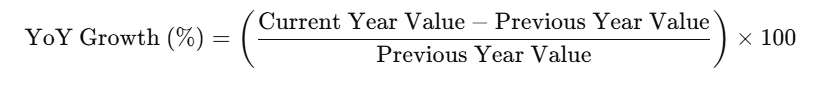

In [83]:
import pandas as pd
import plotly.graph_objects as go

# Ensure datetime format
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')

# Extract year and count projects
df_projects['start_dt_year'] = df_projects['start_dt'].dt.year
created_year_counts = (
    df_projects['start_dt_year']
    .value_counts()
    .sort_index()
    .reset_index()
)
created_year_counts.columns = ['Year', 'Project Count']

# YoY Growth
created_year_counts['YoY Growth (%)'] = created_year_counts['Project Count'].pct_change().fillna(0) * 100
created_year_counts['YoY Growth (%)'] = created_year_counts['YoY Growth (%)'].round(2)

# Marker color based on growth
created_year_counts['marker_color'] = created_year_counts['YoY Growth (%)'].apply(
    lambda x: 'green' if x >= 0 else 'red'
)

# Hover text
created_year_counts['hover'] = created_year_counts.apply(
    lambda row: f"Year: {row['Year']}<br>Projects: {row['Project Count']}<br>YoY Growth: {row['YoY Growth (%)']}%", axis=1
)

# Plot using plotly.graph_objects
fig = go.Figure()

# Add line trace
fig.add_trace(go.Scatter(
    x=created_year_counts['Year'],
    y=created_year_counts['Project Count'],
    mode='lines',
    line=dict(color='royalblue', width=3),
    name='Project Trend'
))

# Add colored markers
fig.add_trace(go.Scatter(
    x=created_year_counts['Year'],
    y=created_year_counts['Project Count'],
    mode='markers',
    marker=dict(
        size=10,
        color=created_year_counts['marker_color']
    ),
    hovertext=created_year_counts['hover'],
    hoverinfo='text',
    name='Growth Marker'
))

# Annotate peak year
peak_row = created_year_counts.loc[created_year_counts['Project Count'].idxmax()]
fig.add_annotation(
    x=peak_row['Year'],
    y=peak_row['Project Count'],
    text=f"Peak: {peak_row['Project Count']} projects",
    showarrow=True,
    arrowhead=2,
    ax=20,
    ay=-30,
    bgcolor='lightgreen',
    bordercolor='green'
)

# Final layout
fig.update_layout(
    title='Chart 6: Projects Start per Year with YoY Growth Indicators',
    xaxis_title='Year',
    title_x=0.5,
    yaxis_title='Project Count',
    xaxis=dict(dtick=1),
    hovermode="x unified"
)

fig.show()


# Section 2 - Analysis Log Hour Against Issue - Since 1 Year

### Time to Decimal Implementation

In [15]:
def time_to_decimal(time_str):
    # Handle string input
    if isinstance(time_str, str):
        time_str = time_str.strip()

        # Check if input is a time string with colons
        if ':' in time_str:
            parts = time_str.split(':')
            try:
                parts = list(map(int, parts))
                if len(parts) == 2:
                    hours, minutes = parts
                    seconds = 0
                elif len(parts) == 3:
                    hours, minutes, seconds = parts
                else:
                    return None
                return round(hours + minutes/60 + seconds/3600, 2)
            except ValueError:
                return None

        # Check if input is a number (integer or decimal)
        try:
            value = float(time_str)
            # If it's a whole number, treat as hours
            if value.is_integer():
                return float(int(value))
            # If it's a decimal, return as is
            return round(value, 2)
        except ValueError:
            return None

    # Handle non-string input (e.g., float or int)
    elif isinstance(time_str, (int, float)):
        # If it's a whole number, treat as hours
        if float(time_str).is_integer():
            return float(int(time_str))
        # If it's a decimal, return as is
        return round(float(time_str), 2)

    return None

In [16]:
# set(df_log_hour_issue['work_duration'].unique())
print('3','->',time_to_decimal('3'))
print('3.5','->',time_to_decimal('3.5'))
print('3:50','->',time_to_decimal('3:50'))
print('3:30:30','->',time_to_decimal('3:30:30'))
print('13','->',time_to_decimal('13'))
print('3.8','->',time_to_decimal('3.8'))
print('03:10:30','->',time_to_decimal('03:10:30'))
print('4.17','->',time_to_decimal('4.17'))
print('10:00:00','->',time_to_decimal('10:00:00'))
print('0.01','->',time_to_decimal('0.01'))
print('30','->',time_to_decimal('30'))
print('0:30','->',time_to_decimal('0:30'))
print('0:144','->',time_to_decimal('0:144'))
print('160','->',time_to_decimal('160'))
print('0.001','->',time_to_decimal('0.001'))
print('5:00','->',time_to_decimal('5:00'))
print('10:00','->',time_to_decimal('10:00'))

3 -> 3.0
3.5 -> 3.5
3:50 -> 3.83
3:30:30 -> 3.51
13 -> 13.0
3.8 -> 3.8
03:10:30 -> 3.17
4.17 -> 4.17
10:00:00 -> 10.0
0.01 -> 0.01
30 -> 30.0
0:30 -> 0.5
0:144 -> 2.4
160 -> 160.0
0.001 -> 0.0
5:00 -> 5.0
10:00 -> 10.0


### Project & Unique Milestone Distribution + Effort

In [84]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# === Prepare Data ===

# 1) Unique projects per category (Pie 1)
unique_project_counts = (
    df_log_hour_issue
      .assign(EBS_project_name=lambda d: d['EBS_project_name'].astype(str).str.strip())
      .groupby('ProjectCategory')['EBS_project_name']
      .nunique(dropna=True)
      .reset_index()
      .rename(columns={'EBS_project_name': 'Unique Project Count'})
)

# 2) UNIQUE milestones per category (Pie 2)  <-- FIXED
MILESTONE_COL = 'Milestone'  # <-- change this if your column has a different name
milestone_counts = (
    df_log_hour_issue
      .assign(**{MILESTONE_COL: df_log_hour_issue[MILESTONE_COL].astype(str).str.strip()})
      .groupby('ProjectCategory')[MILESTONE_COL]
      .nunique(dropna=True)
      .reset_index(name='Unique Milestone Count')
)

# 3) Total hours per category (Bar)
df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)
total_hour_counts = (
    df_log_hour_issue
      .groupby('ProjectCategory', as_index=False)['work_hours']
      .sum()
)
total_hour_counts['Days'] = total_hour_counts['work_hours'] / 8.0

# === Create Subplots ===
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'xy'}]],
    subplot_titles=[
        "<b>Projects by Category</b>",
        "<b>Unique Milestones by Category</b>",   # updated title
        "<b>Total Effort (Hours) by Category</b>"
    ],
    column_widths=[0.3, 0.3, 0.4]
)

# --- Pie 1: Unique Projects ---
fig.add_trace(
    go.Pie(
        labels=unique_project_counts['ProjectCategory'],
        values=unique_project_counts['Unique Project Count'],
        textinfo='label+value+percent',
        name="Unique Projects",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc')
                            for cat in unique_project_counts['ProjectCategory']]),
        hole=0.1
    ),
    row=1, col=1
)

# --- Pie 2: Unique Milestones ---
fig.add_trace(
    go.Pie(
        labels=milestone_counts['ProjectCategory'],
        values=milestone_counts['Unique Milestone Count'],
        textinfo='label+value+percent',
        name="Unique Milestones",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc')
                            for cat in milestone_counts['ProjectCategory']]),
        hole=0.1
    ),
    row=1, col=2
)

# --- Bar: Total Hours ---
fig.add_trace(
    go.Bar(
        x=total_hour_counts['ProjectCategory'],
        y=total_hour_counts['work_hours'],
        marker_color=[project_category_color_discrete_map.get(cat, '#ccc')
                      for cat in total_hour_counts['ProjectCategory']],
        text=total_hour_counts['work_hours'].round(2),
        textposition='auto',
        name="work_hours",
        customdata=total_hour_counts['Days'],
        hovertemplate="<b>%{x}</b><br>Total: %{y:.2f} hours<br>≈ %{customdata:.2f} days (8h/day)<extra></extra>",
    ),
    row=1, col=3
)

# --- Layout ---
fig.update_layout(
    title_text="Chart 7: Project & Unique Milestone Distribution + Effort",
    title_x=0.5,
    height=500,
    margin=dict(t=60, b=100, l=40, r=40),
    showlegend=False
)
fig.update_yaxes(title_text="Total Hour", row=1, col=3)
fig.update_xaxes(title_text="Project Category", row=1, col=3)

fig.show()


## Top 10 Projects by Total Hours — filter by Project Category

In [85]:
import pandas as pd
import plotly.graph_objects as go

# --- config ---
COST_PER_HOUR = 1000  # ৳ per hour

def count_issues(s: pd.Series) -> int:
    return s.dropna().astype(str).str.strip().ne('').sum()

# Reusable hover template (now includes Expected Cost)
# customdata order: [days, expected_cost, issue_count, person_count, milestone_count, ProjectCategory, project_type]
HOVER_TMPL = (
    "<b>%{y}</b><br>"
    "Total Hours: %{x:.2f} h<br>"
    "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
    "≈ %{customdata[0]:.2f} days (8h/day)<br>"
    "Total Issues: %{customdata[2]}<br>"
    "Number of Resource: %{customdata[3]}<br>"
    "Number of Milestone: %{customdata[4]}<br>"
    "Category: %{customdata[5]}<br>"
    "Project Type: %{customdata[6]}"
    "<extra></extra>"
)

# Optional color map per category
# project_category_color_discrete_map = {"Internal": "#1f77b4", "Client": "#2ca02c", ...}

# --- data & aggregate per project ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

proj_agg = (
    df.dropna(subset=['EBS_project_name'])
      .groupby('EBS_project_name', as_index=False)
      .agg(
          total_hours     = ('work_hours', 'sum'),
          issue_count     = ('issue_details', count_issues),
          person_count    = ('user_email', lambda s: s.dropna().nunique()),
          milestone_count = ('Milestone',  lambda s: s.dropna().nunique()),
          ProjectCategory = ('ProjectCategory', lambda s: s.mode().iat[0] if not s.mode().empty else None),
          project_type    = ('type',            lambda s: s.mode().iat[0] if not s.mode().empty else None),
      )
)

# safety fills
proj_agg['total_hours'] = proj_agg['total_hours'].fillna(0.0)
proj_agg['issue_count'] = proj_agg['issue_count'].fillna(0).astype(int)
proj_agg['person_count'] = proj_agg['person_count'].fillna(0).astype(int)
proj_agg['milestone_count'] = proj_agg['milestone_count'].fillna(0).astype(int)

# derived fields
proj_agg['days'] = proj_agg['total_hours'] / 8.0
proj_agg['expected_cost'] = proj_agg['total_hours'] * COST_PER_HOUR  # ✅ add expected cost (৳)

# --- category list ---
categories = ['All'] + sorted([c for c in proj_agg['ProjectCategory'].dropna().unique()])

# --- top-10 by HOURS within category ---
top_n = 10
def top_df_for_hours(cat):
    d = proj_agg if cat == 'All' else proj_agg[proj_agg['ProjectCategory'] == cat]
    return d.sort_values('total_hours', ascending=False).head(top_n).reset_index(drop=True)

def colors_for(cat, d):
    if 'project_category_color_discrete_map' in globals():
        if cat == 'All':
            return d['ProjectCategory'].map(project_category_color_discrete_map).fillna('#636EFA').tolist()
        return [project_category_color_discrete_map.get(cat, '#636EFA')] * len(d)
    return ['#636EFA'] * len(d)

# --- build figure (single chart) ---
init_cat = 'All'
d0 = top_df_for_hours(init_cat)
c0 = colors_for(init_cat, d0)

fig = go.Figure()

fig.add_bar(
    x=d0['total_hours'],
    y=d0['EBS_project_name'],
    orientation='h',
    marker=dict(color=c0),
    text=[f"Resource:{p} | Hours:{h:.1f}h | Milestone:{m} | Issue:{i}"
          for h,i,p,m in zip(d0['total_hours'], d0['issue_count'], d0['person_count'], d0['milestone_count'])],
    textposition='auto',
    customdata=d0[['days','expected_cost','issue_count','person_count','milestone_count','ProjectCategory','project_type']].values,
    hovertemplate=HOVER_TMPL,
    name="Total Hours"
)

# --- frames: one per category (top-10 by hours) ---
frames = []
for cat in categories:
    d = top_df_for_hours(cat)
    c = colors_for(cat, d)
    frames.append(go.Frame(
        name=cat,
        data=[go.Bar(
            x=d['total_hours'],
            y=d['EBS_project_name'],
            orientation='h',
            marker=dict(color=c),
            text=[f"Resoruce:{p} | Hours:{h:.1f}h | Milestone:{m} | Issue:{i}"
                  for h,i,p,m in zip(d['total_hours'], d['issue_count'], d['person_count'], d['milestone_count'])],
            textposition='auto',
            customdata=d[['days','expected_cost','issue_count','person_count','milestone_count','ProjectCategory','project_type']].values,
            hovertemplate=HOVER_TMPL,
            name="Total Hours"
        )]
    ))
fig.frames = frames

# --- dropdown ---
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        direction="down",
        x=1, y=1.12, xanchor="center", yanchor="top",
        buttons=[
            dict(label=cat, method="animate",
                 args=[[cat], {"mode":"immediate","frame":{"duration":0,"redraw":True},"transition":{"duration":0}}])
            for cat in categories
        ],
        showactive=True
    )],
    title="Chart 8: Top 10 Projects by Total Hours — filter by Project Category",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Project",
    bargap=0.2,
    height=650,
    margin=dict(l=160, r=40, t=80, b=60),
    hovermode='y unified',
    hoverdistance=-1,
    hoverlabel=dict(namelength=-1)
)

# biggest on top
fig.update_yaxes(autorange="reversed")

fig.show()


## Team-wise Ranking by Total Logged Hours

In [86]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour

# --- prep data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- aggregate per team ---
team_agg = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          milestone_count=('Milestone', lambda s: s.dropna().nunique())
      )
)

# derived
team_agg['days'] = team_agg['total_hours'] / 8.0
team_agg['expected_cost'] = team_agg['total_hours'] * COST_PER_HOUR  # ✅ add cost

# sort + rank
team_agg = team_agg.sort_values('total_hours', ascending=False).reset_index(drop=True)
team_agg['rank'] = team_agg.index + 1
team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']

# optional: top-N
top_n = 20
plot_df = team_agg.head(top_n).copy()

# bar text (includes expected cost)
plot_df['label'] = plot_df.apply(
    lambda r: (
        f"H:{r['total_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | "
        f"Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}"
    ),
    axis=1
)

# --- chart: team-wise ranking by hours ---
fig = px.bar(
    plot_df,
    x='total_hours',
    y='team_label',
    orientation='h',
    color='total_hours',
    color_continuous_scale='RdYlGn',
    text='label',
    title='Chart 9: Team-wise Ranking by Total Logged Hours',
    labels={'team_label': 'Team (ranked)', 'total_hours': 'Total Hours'},
    custom_data=['days','expected_cost','member_count','project_count','milestone_count','log_count','team_name']
)

fig.update_traces(
    textposition='auto',
    hovertemplate=(
        "<b>%{customdata[6]}</b><br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Number of Resource: %{customdata[2]}<br>"
        "Projects: %{customdata[3]}<br>"
        "Milestones: %{customdata[4]}<br>"
        "Log Count: %{customdata[5]}<extra></extra>"
    )
)

fig.update_layout(
    hovermode='y unified',
    hoverdistance=-1,
    title_x=0.5,
    bargap=0.2,
    height=800,
    margin=dict(l=200, r=60, t=80, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

# biggest on top
fig.update_yaxes(autorange='reversed')

fig.show()


### Team-wise Ranking by Average Logged Hours per Resource

In [88]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour

# --- prep data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- aggregate per team ---
team_agg = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          milestone_count=('Milestone', lambda s: s.dropna().nunique())
      )
)

# derived
team_agg['avg_hours'] = team_agg['total_hours'] / team_agg['member_count']
team_agg['days'] = team_agg['total_hours'] / 8.0
team_agg['expected_cost'] = team_agg['total_hours'] * COST_PER_HOUR  # ✅ add cost

# sort + rank
team_agg = team_agg.sort_values('avg_hours', ascending=False).reset_index(drop=True)
team_agg['rank'] = team_agg.index + 1
team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']

# optional: top-N
top_n = 20
plot_df = team_agg.head(top_n).copy()

# bar text (includes expected cost)
plot_df['label'] = plot_df.apply(
    lambda r: (
        f"Avg:{r['avg_hours']:.1f}h/res | H:{r['total_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | "
        f"Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}"
    ),
    axis=1
)

# --- chart: team-wise ranking by hours ---
fig = px.bar(
    plot_df,
    x='avg_hours',
    y='team_label',
    orientation='h',
    color='avg_hours',
    color_continuous_scale='RdYlGn',
    text='label',
    title='Chart 10: Team-wise Ranking by Average Logged Hours per Resource',
    labels={'team_label': 'Team (ranked)', 'avg_hours': 'Average Hours per Resource'},

    custom_data=['total_hours','days','expected_cost','member_count','project_count','milestone_count','log_count','team_name']
)

fig.update_traces(
    textposition='auto',
    hovertemplate=(
        "<b>%{customdata[7]}</b><br>"
        "Average Hours per Resource: %{x:.2f} h<br>"
        "Total Hours: %{customdata[0]:.2f} h<br>"
        "Expected Cost: %{customdata[2]:,.0f} ৳<br>"
        "≈ %{customdata[1]:.2f} days (8h/day)<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Projects: %{customdata[4]}<br>"
        "Milestones: %{customdata[5]}<br>"
        "Log Count: %{customdata[6]}<extra></extra>"
    )
)

fig.update_layout(
    hovermode='y unified',
    hoverdistance=-1,
    title_x=0.5,
    bargap=0.2,
    height=800,
    margin=dict(l=200, r=60, t=80, b=60),
    coloraxis_colorbar=dict(title="Avg Hours")
)

# biggest on top
fig.update_yaxes(autorange='reversed')

fig.show()

### Team Ranking by Project Category (Top 10 by Hours)

In [89]:
import pandas as pd
import plotly.graph_objects as go

COST_PER_HOUR = 1000   # ৳ per hour
TOP_N = 10
CATEGORY = "commercial"

# --- Base & filter ---
df = df_log_hour_issue.copy()

# Make sure work_hours exists
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Normalize category text a bit (optional but helpful)
df['ProjectCategory'] = df['ProjectCategory'].astype(str).str.strip()
df = df[df['ProjectCategory'].str.lower() == CATEGORY.lower()]

# Early exit if nothing to show
if df.empty:
    raise ValueError(f'No rows found for ProjectCategory="{CATEGORY}".')

# --- Aggregate per team (within the category) ---
team_stats = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          ProjectCategory=('ProjectCategory', 'first')  # Get the category of the team
      )
)

# Derived metrics
team_stats['days'] = team_stats['total_hours'] / 8.0
team_stats['expected_cost'] = team_stats['total_hours'] * COST_PER_HOUR

# Ranking (Top N by total_hours)
team_stats = team_stats.sort_values('total_hours', ascending=False).head(TOP_N).reset_index(drop=True)
team_stats['rank'] = team_stats.index + 1
team_stats['team_label'] = team_stats['rank'].astype(str) + '. ' + team_stats['team_name']

# --- Map ProjectCategory to color using project_category_color_discrete_map ---
team_stats['color'] = team_stats['ProjectCategory'].map(project_category_color_discrete_map)

# --- Plot ---
fig = go.Figure()

fig.add_bar(
    x=team_stats['total_hours'],
    y=team_stats['team_label'],
    orientation='h',
    marker=dict(color=team_stats['color']),
    text=[
        f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
        for h, cost, p, m, l in zip(
            team_stats['total_hours'],
            team_stats['expected_cost'],
            team_stats['project_count'],
            team_stats['member_count'],
            team_stats['log_count']
        )
    ],
    textposition='auto',
    # customdata: [days, expected_cost, project_count, member_count, log_count, team_name]
    customdata=team_stats[['days','expected_cost','project_count','member_count','log_count','team_name']].values,
    hovertemplate=(
        "<b>%{customdata[5]}</b> — " + CATEGORY.title() + "<br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Projects: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Log Count: %{customdata[4]}<extra></extra>"
    ),
    name="Hours"
)

# Biggest at top
fig.update_yaxes(autorange='reversed')

fig.update_layout(
    title=f"Chart 11: Team Ranking — {CATEGORY.title()} (Top {TOP_N} by Total Hours)",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Team (ranked)",
    hovermode='y unified',
    bargap=0.2,
    height=650,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

fig.show()


In [90]:
import pandas as pd
import plotly.graph_objects as go

COST_PER_HOUR = 1000   # ৳ per hour
TOP_N = 10
CATEGORY = "Non-commercial"

# --- Base & filter ---
df = df_log_hour_issue.copy()

# Make sure work_hours exists
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Normalize category text a bit (optional but helpful)
df['ProjectCategory'] = df['ProjectCategory'].astype(str).str.strip()
df = df[df['ProjectCategory'].str.lower() == CATEGORY.lower()]

# Early exit if nothing to show
if df.empty:
    raise ValueError(f'No rows found for ProjectCategory="{CATEGORY}".')

# --- Aggregate per team (within the category) ---
team_stats = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          ProjectCategory=('ProjectCategory', 'first')  # Get the category of the team
      )
)

# Derived metrics
team_stats['days'] = team_stats['total_hours'] / 8.0
team_stats['expected_cost'] = team_stats['total_hours'] * COST_PER_HOUR

# Ranking (Top N by total_hours)
team_stats = team_stats.sort_values('total_hours', ascending=False).head(TOP_N).reset_index(drop=True)
team_stats['rank'] = team_stats.index + 1
team_stats['team_label'] = team_stats['rank'].astype(str) + '. ' + team_stats['team_name']

# --- Map ProjectCategory to color using project_category_color_discrete_map ---
team_stats['color'] = team_stats['ProjectCategory'].map(project_category_color_discrete_map)

# --- Plot ---
fig = go.Figure()

fig.add_bar(
    x=team_stats['total_hours'],
    y=team_stats['team_label'],
    orientation='h',
    marker=dict(color=team_stats['color']),
    text=[
        f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
        for h, cost, p, m, l in zip(
            team_stats['total_hours'],
            team_stats['expected_cost'],
            team_stats['project_count'],
            team_stats['member_count'],
            team_stats['log_count']
        )
    ],
    textposition='auto',
    # customdata: [days, expected_cost, project_count, member_count, log_count, team_name]
    customdata=team_stats[['days','expected_cost','project_count','member_count','log_count','team_name']].values,
    hovertemplate=(
        "<b>%{customdata[5]}</b> — " + CATEGORY.title() + "<br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Projects: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Log Count: %{customdata[4]}<extra></extra>"
    ),
    name="Hours"
)

# Biggest at top
fig.update_yaxes(autorange='reversed')

fig.update_layout(
    title=f"Chart 12: Team Ranking — {CATEGORY.title()} (Top {TOP_N} by Total Hours)",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Team (ranked)",
    hovermode='y unified',
    bargap=0.2,
    height=650,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

fig.show()


In [91]:
import pandas as pd
import plotly.graph_objects as go

COST_PER_HOUR = 1000   # ৳ per hour
TOP_N = 10
CATEGORY = "Others"

# --- Base & filter ---
df = df_log_hour_issue.copy()

# Make sure work_hours exists
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Normalize category text a bit (optional but helpful)
df['ProjectCategory'] = df['ProjectCategory'].astype(str).str.strip()
df = df[df['ProjectCategory'].str.lower() == CATEGORY.lower()]

# Early exit if nothing to show
if df.empty:
    raise ValueError(f'No rows found for ProjectCategory="{CATEGORY}".')

# --- Aggregate per team (within the category) ---
team_stats = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          ProjectCategory=('ProjectCategory', 'first')  # Get the category of the team
      )
)

# Derived metrics
team_stats['days'] = team_stats['total_hours'] / 8.0
team_stats['expected_cost'] = team_stats['total_hours'] * COST_PER_HOUR

# Ranking (Top N by total_hours)
team_stats = team_stats.sort_values('total_hours', ascending=False).head(TOP_N).reset_index(drop=True)
team_stats['rank'] = team_stats.index + 1
team_stats['team_label'] = team_stats['rank'].astype(str) + '. ' + team_stats['team_name']

# --- Map ProjectCategory to color using project_category_color_discrete_map ---
team_stats['color'] = team_stats['ProjectCategory'].map(project_category_color_discrete_map)

# --- Plot ---
fig = go.Figure()

fig.add_bar(
    x=team_stats['total_hours'],
    y=team_stats['team_label'],
    orientation='h',
    marker=dict(color=team_stats['color']),
    text=[
        f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
        for h, cost, p, m, l in zip(
            team_stats['total_hours'],
            team_stats['expected_cost'],
            team_stats['project_count'],
            team_stats['member_count'],
            team_stats['log_count']
        )
    ],
    textposition='auto',
    # customdata: [days, expected_cost, project_count, member_count, log_count, team_name]
    customdata=team_stats[['days','expected_cost','project_count','member_count','log_count','team_name']].values,
    hovertemplate=(
        "<b>%{customdata[5]}</b> — " + CATEGORY.title() + "<br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Projects: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Log Count: %{customdata[4]}<extra></extra>"
    ),
    name="Hours"
)

# Biggest at top
fig.update_yaxes(autorange='reversed')

fig.update_layout(
    title=f"Chart 13: Team Ranking — {CATEGORY.title()} (Top {TOP_N} by Total Hours)",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Team (ranked)",
    hovermode='y unified',
    bargap=0.2,
    height=650,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

fig.show()


In [94]:
import pandas as pd
import plotly.graph_objects as go

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 10

# --- Base data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- Aggregate per (ProjectCategory, team) ---
team_cat = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['ProjectCategory', 'team_name'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique())
      )
)

# Derived metrics
team_cat['days'] = team_cat['total_hours'] / 8.0
team_cat['expected_cost'] = team_cat['total_hours'] * COST_PER_HOUR

# Categories
categories = sorted(team_cat['ProjectCategory'].dropna().unique().tolist())

def top_df(cat):
    d = team_cat[team_cat['ProjectCategory'] == cat].sort_values('total_hours', ascending=False).head(TOP_N).copy()
    d.reset_index(drop=True, inplace=True)
    d['rank'] = d.index + 1
    d['team_label'] = d['rank'].astype(str) + '. ' + d['team_name']
    return d

# --- Initial category ---
init_cat = categories[0] if categories else None
d0 = top_df(init_cat) if init_cat else team_cat.head(0)

# --- Apply project_category_color_discrete_map ---
# Map each ProjectCategory to the respective color
d0['color'] = d0['ProjectCategory'].map(project_category_color_discrete_map).fillna('gray')  # Default to 'gray' if no color found

# Build figure
fig = go.Figure()

fig.add_bar(
    x=d0['total_hours'],
    y=d0['team_label'],
    orientation='h',
    marker=dict(color=d0['color']),
    text=[f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
          for h, cost, p, m, l in zip(d0['total_hours'], d0['expected_cost'], d0['project_count'], d0['member_count'], d0['log_count'])],
    textposition='auto',
    customdata=d0[['days', 'expected_cost', 'project_count', 'member_count', 'log_count', 'team_name', 'ProjectCategory']].values,
    hovertemplate=(
        "<b>%{customdata[5]}</b> — %{customdata[6]}<br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Projects: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Log Count: %{customdata[4]}<extra></extra>"
    ),
    name="Hours"
)

# --- Frames for each category ---
frames = []
for cat in categories:
    d = top_df(cat)
    # Map each ProjectCategory to the respective color for each frame
    d['color'] = d['ProjectCategory'].map(project_category_color_discrete_map).fillna('gray')  # Default to 'gray'

    frames.append(go.Frame(
        name=cat,
        data=[go.Bar(
            x=d['total_hours'],
            y=d['team_label'],
            orientation='h',
            marker=dict(color=d['color']),
            text=[f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
                  for h, cost, p, m, l in zip(d['total_hours'], d['expected_cost'], d['project_count'], d['member_count'], d['log_count'])],
            textposition='auto',
            customdata=d[['days', 'expected_cost', 'project_count', 'member_count', 'log_count', 'team_name', 'ProjectCategory']].values,
            hovertemplate=(
                "<b>%{customdata[5]}</b> — %{customdata[6]}<br>"
                "Total Hours: %{x:.2f} h<br>"
                "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
                "≈ %{customdata[0]:.2f} days (8h/day)<br>"
                "Projects: %{customdata[2]}<br>"
                "Number of Resource: %{customdata[3]}<br>"
                "Log Count: %{customdata[4]}<extra></extra>"
            ),
            name="Hours"
        )]
    ))
fig.frames = frames

# --- Dropdown to pick ProjectCategory ---
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        x=1, y=1.12, xanchor="center", yanchor="top",
        showactive=True,
        buttons=[
            dict(label=cat, method="animate",
                 args=[[cat], {"mode": "immediate", "frame": {"duration": 0, "redraw": True}, "transition": {"duration": 0}}])
            for cat in categories
        ],
    )],
    title="Chart 14: Team Ranking by Filtering Project Category (Top 10 by Hours)",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Team (ranked)",
    hovermode='y unified',
    hoverdistance=-1,
    bargap=0.2,
    height=650,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

# Biggest on top
fig.update_yaxes(autorange='reversed')

fig.show()


In [96]:
import pandas as pd
import plotly.graph_objects as go

# --- Base data preparation ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- Aggregate total hours per (team, ProjectCategory) ---
team_category_hours = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['team_name', 'ProjectCategory'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum')  # Sum of work hours
      )
)

# Pivot to get categories as columns for easier stacking
pivot_df = team_category_hours.pivot(
    index='team_name',
    columns='ProjectCategory',
    values='total_hours'
).fillna(0)

# Get all teams and ensure we have all three categories
all_teams = pivot_df.index.tolist()

# Define the three main categories (adjust names as per your actual data)
categories = ['Commercial', 'Non-Commercial', 'Others']

# Ensure all categories exist in the dataframe (add missing ones with 0)
for cat in categories:
    if cat not in pivot_df.columns:
        pivot_df[cat] = 0

# Sort teams by total hours (descending) and add ranking
pivot_df['total_hours'] = pivot_df[categories].sum(axis=1)
pivot_df = pivot_df.sort_values('total_hours', ascending=False)

# Add ranking
pivot_df['rank'] = range(1, len(pivot_df) + 1)
pivot_df['team_label'] = pivot_df['rank'].astype(str) + '. ' + pivot_df.index

# Remove the total column for plotting (keep for reference)
plot_df = pivot_df[categories].copy()
plot_df.index = pivot_df['team_label']  # Use ranked team labels

# Create the stacked bar chart
fig = go.Figure()

# Add traces for each category
for category in categories:
    if category in plot_df.columns:
        fig.add_trace(
            go.Bar(
                name=category,
                x=plot_df.index,
                y=plot_df[category],
                marker_color=project_category_color_discrete_map[category],
                hovertemplate=(
                    f"<b>{category}</b><br>"
                    "Team: %{x}<br>"
                    "Hours: %{y:.1f}h<br>"
                    "<extra></extra>"
                )
            )
        )

# Update layout for stacked bars
fig.update_layout(
    barmode='stack',
    title="Chart 15: Team Ranking by Total Hours - Project Category Distribution",
    title_x=0.5,
    xaxis_title="Team Ranking (Based on Total Hours)",
    yaxis_title="Total Hours",
    # hovermode='x unified',
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=60, r=60, t=100, b=150),  # Extra bottom margin for long team names
    height=700
)

# Rotate x-axis labels if team names are long
fig.update_xaxes(tickangle=45)

# Add total hours annotations on top of each bar
for i, team_label in enumerate(plot_df.index):
    total_hours = plot_df.loc[team_label, categories].sum()
    fig.add_annotation(
        x=i,
        y=total_hours + max(plot_df[categories].sum(axis=1)) * 0.02,  # Slightly above the bar
        text=f"{total_hours:.1f}h",
        showarrow=False,
        font=dict(size=14, color="black")
    )

fig.show()

In [97]:
import pandas as pd
import plotly.graph_objects as go

# --- Base data preparation ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- Aggregate total hours per (team, ProjectCategory) ---
team_category_hours = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['team_name', 'ProjectCategory'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum')  # Sum of work hours
      )
)

# Pivot to get categories as columns for easier stacking
pivot_df = team_category_hours.pivot(
    index='team_name',
    columns='ProjectCategory',
    values='total_hours'
).fillna(0)

# Get all teams and ensure we have all three categories
all_teams = pivot_df.index.tolist()

# Define the three main categories (adjust names as per your actual data)
categories = ['Commercial', 'Non-Commercial', 'Others']

# Ensure all categories exist in the dataframe (add missing ones with 0)
for cat in categories:
    if cat not in pivot_df.columns:
        pivot_df[cat] = 0

# Sort teams by total hours (descending) and add ranking
pivot_df['total_hours'] = pivot_df[categories].sum(axis=1)
pivot_df = pivot_df.sort_values('total_hours', ascending=False)

# Add ranking
pivot_df['rank'] = range(1, len(pivot_df) + 1)
pivot_df['team_label'] = pivot_df['rank'].astype(str) + '. ' + pivot_df.index

# Remove the total column for plotting (keep for reference)
plot_df = pivot_df[categories].copy()
plot_df.index = pivot_df['team_label']  # Use ranked team labels

# Create the stacked bar chart
fig = go.Figure()

# Add traces for each category
for category in categories:
    if category in plot_df.columns:
        fig.add_trace(
            go.Bar(
                name=category,
                x=plot_df.index,
                y=plot_df[category],
                marker_color=project_category_color_discrete_map[category],
                text=plot_df[category],
                hovertemplate=(
                    f"<b>{category}</b><br>"
                    "Team: %{x}<br>"
                    "Hours: %{y:.1f}h<br>"
                    "<extra></extra>"
                )
            )
        )

# Update layout for stacked bars
fig.update_layout(
    barmode='group',
    title="Chart 16: Team Ranking by Total Hours - Project Category Distribution",
    title_x=0.5,
    xaxis_title="Team Ranking (Based on Total Hours)",
    yaxis_title="Total Hours",
    # hovermode='x unified',
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=60, r=60, t=100, b=150),  # Extra bottom margin for long team names
    height=700
)

In [28]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- CONFIG ---
USE_UNIQUE_PROJECTS = True   # count unique EBS_project_name per team/category
TOP_TEAMS = None             # set an int to show only top-N teams by count for the selected category

# --- Helpers ---
def clean_project_name(row):
    name = ('' if pd.isna(row['EBS_project_name']) else str(row['EBS_project_name']).strip())
    if name == '' and str(row.get('ProjectCategory', '')).strip() == 'Others':
        return 'Anonymous'
    return name or 'Unnamed'

# --- Base ---
df = df_log_hour_issue.copy()
df['ProjectNameFixed'] = df.apply(clean_project_name, axis=1)
df = df.dropna(subset=['team_name', 'ProjectCategory']).copy()

if USE_UNIQUE_PROJECTS:
    per_tc = (
        df[['team_name', 'ProjectCategory', 'ProjectNameFixed']]
        .drop_duplicates()
        .groupby(['team_name', 'ProjectCategory'], as_index=False)
        .size().rename(columns={'size': 'project_count'})
    )
    team_totals = (
        df[['team_name', 'ProjectNameFixed']]
        .drop_duplicates()
        .groupby('team_name', as_index=False)
        .size().rename(columns={'size': 'team_total_projects'})
    )
else:
    per_tc = (
        df.groupby(['team_name', 'ProjectCategory'], as_index=False)
          .size().rename(columns={'size': 'project_count'})
    )
    team_totals = (
        df.groupby('team_name', as_index=False)
          .size().rename(columns={'size': 'team_total_projects'})
    )

teams_all = team_totals['team_name'].tolist()

def build_series_for_category(cat):
    d = pd.DataFrame({'team_name': teams_all}).merge(
        per_tc[per_tc['ProjectCategory'] == cat][['team_name', 'project_count']],
        on='team_name', how='left'
    ).merge(team_totals, on='team_name', how='left')

    d['project_count'] = d['project_count'].fillna(0).astype(int)
    d['team_total_projects'] = d['team_total_projects'].fillna(0).astype(int)
    d['pct'] = d.apply(lambda r: (r['project_count'] / r['team_total_projects'] * 100.0) if r['team_total_projects'] > 0 else 0.0, axis=1)

    d = d.sort_values(['project_count', 'pct', 'team_name'], ascending=[False, False, True])
    if TOP_TEAMS:
        d = d.head(TOP_TEAMS)

    return d['team_name'].tolist(), d['project_count'].tolist(), d['pct'].tolist()

categories = sorted(per_tc['ProjectCategory'].dropna().unique().tolist())
if not categories:
    raise ValueError("No ProjectCategory values found.")

init_cat = categories[0]
x0, counts0, pct0 = build_series_for_category(init_cat)
init_color = project_category_color_discrete_map.get(init_cat, '#999')

fig = make_subplots(specs=[[{"secondary_y": True}]])

# --- Bar (counts) with category color from your discrete map ---
bar = go.Bar(
    x=x0, y=counts0, name="Project Count",
    marker=dict(color=init_color),  # <- use single color for the selected category
    hovertemplate="<b>%{x}</b><br>Category: " + init_cat + "<br>Project Count: %{y}<extra></extra>"
)

# --- Line (percentage) ---
line = go.Scatter(
    x=x0, y=pct0, name="Category Share (%)", mode="lines+markers", yaxis="y2",
    hovertemplate="<b>%{x}</b><br>Category: " + init_cat + "<br>Share: %{y:.1f}%<extra></extra>"
)

fig.add_trace(bar, secondary_y=False)
fig.add_trace(line, secondary_y=True)

# --- Dropdown: switch data + bar color per category ---
buttons = []
for cat in categories:
    xt, ct, pt = build_series_for_category(cat)
    cat_color = project_category_color_discrete_map.get(cat, '#999')
    buttons.append(dict(
        label=cat,
        method="update",
        args=[
            # Per-trace updates
            {
                "x": [xt, xt],
                "y": [ct, pt],
                "hovertemplate": [
                    "<b>%{x}</b><br>Category: " + cat + "<br>Project Count: %{y}<extra></extra>",
                    "<b>%{x}</b><br>Category: " + cat + "<br>Share: %{y:.1f}%<extra></extra>"
                ],
                # Set bar trace (trace 0) color; keep line (trace 1) unchanged
                "marker": [ {"color": cat_color}, {} ]
            },
            # Layout updates (keep team order stable to the new xt)
            {"xaxis": {"categoryorder": "array", "categoryarray": xt}}
        ]
    ))

fig.update_layout(
    title="Chart 17: Team vs Project Category — Project Count & Share",
    title_x=0.5,
    xaxis_title="Team",
    yaxis_title="Project Count",
    yaxis2_title="Share of Team Projects (%)",
    yaxis2=dict(range=[0, 100]),
    hovermode='x unified',
    hoverdistance=-1,
    margin=dict(l=60, r=60, t=70, b=80),
    updatemenus=[dict(
        type="dropdown",
        x=1.0, y=1.15, xanchor="center", yanchor="top",
        showactive=True,
        buttons=buttons
    )]
)

fig.show()


## Anonymous Projects Analysis
- No Project Name but work hour assigned with the resource

In [29]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 20

def uniq_join(series, limit=12):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br>".join(vals)
    return "<br>".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- base ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Anonymous rows: empty EBS_project_name AND ProjectCategory == "Others"
name_clean = df['EBS_project_name'].fillna('').astype(str).str.strip()
anon_mask = (df['ProjectCategory'] == 'Others') & (name_clean == '')

df_anon = df.loc[anon_mask].dropna(subset=['team_name']).copy()

if df_anon.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No anonymous project logs found']}),
        x=[0], y='Message',
        title='Team-wise Percentage — Anonymous Projects',
        labels={'x': 'Percentage (%)', 'Message': ''}
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # Aggregate per team for anonymous (now also collecting member emails)
    team_agg = (
        df_anon.groupby('team_name', as_index=False)
               .agg(
                   anon_hours=('work_hours', 'sum'),
                   log_count=('work_hours', 'count'),
                   member_count=('user_email', lambda s: s.dropna().nunique()),
                   member_emails=('user_email', lambda s: uniq_join(s, limit=20))  # ← emails for hover
               )
    )

    # Compute total hours for all projects per team
    team_total = (
        df.dropna(subset=['team_name'])
          .groupby('team_name', as_index=False)
          .agg(total_hours_all=('work_hours', 'sum'))
    )

    # Merge to get total_hours_all
    team_agg = team_agg.merge(team_total, on='team_name', how='left')

    # Calculate percentage
    team_agg['percentage'] = (team_agg['anon_hours'] / team_agg['total_hours_all']) * 100

    # Derivatives (based on anonymous)
    team_agg['days'] = team_agg['anon_hours'] / 8.0
    team_agg['expected_cost'] = team_agg['anon_hours'] * COST_PER_HOUR

    # Rank + top-N (sort by percentage descending)
    team_agg = team_agg.sort_values('percentage', ascending=False).reset_index(drop=True)
    team_agg['rank'] = team_agg.index + 1
    team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']
    plot_df = team_agg.head(TOP_N).copy()

    # Bar text
    plot_df['label'] = plot_df.apply(
        lambda r: f"Anonymous: {r['percentage']:.1f}% | H:{r['anon_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}",
        axis=1
    )

    # Chart
    fig = px.bar(
        plot_df,
        x='percentage',
        y='team_label',
        orientation='h',
        text='label',
        color_discrete_sequence=['orange'],
        title='Chart 18: Team-wise Percentage of Hours Spent on Anonymous Projects',
        labels={'team_label': 'Team (ranked)', 'percentage': 'Anonymous Percentage (%)'},
        custom_data=['days','expected_cost','member_count','log_count','team_name','member_emails','anon_hours','total_hours_all']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{customdata[4]}</b> — Anonymous Projects<br>"
            "Percentage: %{x:.2f}%<br>"
            "Anonymous Hours: %{customdata[6]:.2f} h<br>"
            "Total Hours (All Projects): %{customdata[7]:.2f} h<br>"
            "Expected Cost (Anonymous): %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Number of Resource (Anonymous): %{customdata[2]}<br>"
            "Log Count (Anonymous): %{customdata[3]}<br>"
            "<br><b>Resource Emails (Anonymous)</b>:<br>%{customdata[5]}<extra></extra>"
        ),
        cliponaxis=False
    )

    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        height=700,
        coloraxis_colorbar=dict(title="Anonymous Percentage (%)")
    )
    fig.update_yaxes(autorange='reversed')  # biggest on top
    fig.show()

In [98]:
import pandas as pd
import plotly.graph_objects as go

# --- Base data preparation ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- Aggregate total hours per (team, ProjectCategory) ---
team_category_hours = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['team_name', 'ProjectCategory'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum')  # Sum of work hours
      )
)

# Pivot to get categories as columns for easier stacking
pivot_df = team_category_hours.pivot(
    index='team_name',
    columns='ProjectCategory',
    values='total_hours'
).fillna(0)

# Get all teams and ensure we have all three categories
all_teams = pivot_df.index.tolist()

# Define the three main categories (adjust names as per your actual data)
categories = ['Commercial', 'Non-Commercial', 'Others']

# Ensure all categories exist in the dataframe (add missing ones with 0)
for cat in categories:
    if cat not in pivot_df.columns:
        pivot_df[cat] = 0

# Sort teams by total hours (descending) and add ranking
pivot_df['total_hours'] = pivot_df[categories].sum(axis=1)
pivot_df = pivot_df.sort_values('total_hours', ascending=False)

# Add ranking
pivot_df['rank'] = range(1, len(pivot_df) + 1)
pivot_df['team_label'] = pivot_df['rank'].astype(str) + '. ' + pivot_df.index

# Remove the total column for plotting (keep for reference)
plot_df = pivot_df[categories].copy()
plot_df.index = pivot_df['team_label']  # Use ranked team labels

# Create the stacked bar chart
fig = go.Figure()

# Add traces for each category
for category in categories:
    if category in plot_df.columns:
        fig.add_trace(
            go.Bar(
                name=category,
                x=plot_df.index,
                y=plot_df[category],
                marker_color=project_category_color_discrete_map[category],
                hovertemplate=(
                    f"<b>{category}</b><br>"
                    "Team: %{x}<br>"
                    "Hours: %{y:.1f}h<br>"
                    "<extra></extra>"
                )
            )
        )

# Update layout for stacked bars
fig.update_layout(
    barmode='stack',
    title="Chart 19: Team Ranking by Total Hours - Project Category Distribution",
    title_x=0.5,
    xaxis_title="Team Ranking (Based on Total Hours)",
    yaxis_title="Total Hours",
    # hovermode='x unified',
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.02,
        xanchor="center",
        x=0.5
    ),
    margin=dict(l=60, r=60, t=100, b=150),  # Extra bottom margin for long team names
    height=700
)

# Rotate x-axis labels if team names are long
fig.update_xaxes(tickangle=45)

# Add total hours annotations on top of each bar
for i, team_label in enumerate(plot_df.index):
    total_hours = plot_df.loc[team_label, categories].sum()
    fig.add_annotation(
        x=i,
        y=total_hours + max(plot_df[categories].sum(axis=1)) * 0.02,  # Slightly above the bar
        text=f"{total_hours:.1f}h",
        showarrow=False,
        font=dict(size=14, color="black")
    )

fig.show()



import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 20

def uniq_join(series, limit=12):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br>".join(vals)
    return "<br>".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- base ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Anonymous rows: empty EBS_project_name AND ProjectCategory == "Others"
name_clean = df['EBS_project_name'].fillna('').astype(str).str.strip()
anon_mask = (df['ProjectCategory'] == 'Others') & (name_clean == '')

df_anon = df.loc[anon_mask].dropna(subset=['team_name']).copy()

if df_anon.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No anonymous project logs found']}),
        x=[0], y='Message',
        title='Team-wise Percentage — Anonymous Projects',
        labels={'x': 'Percentage (%)', 'Message': ''}
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # Aggregate per team for anonymous (now also collecting member emails)
    team_agg = (
        df_anon.groupby('team_name', as_index=False)
               .agg(
                   anon_hours=('work_hours', 'sum'),
                   log_count=('work_hours', 'count'),
                   member_count=('user_email', lambda s: s.dropna().nunique()),
                   member_emails=('user_email', lambda s: uniq_join(s, limit=20))  # ← emails for hover
               )
    )

    # Compute total hours for all projects per team
    team_total = (
        df.dropna(subset=['team_name'])
          .groupby('team_name', as_index=False)
          .agg(total_hours_all=('work_hours', 'sum'))
    )

    # Merge to get total_hours_all
    team_agg = team_agg.merge(team_total, on='team_name', how='left')

    # Calculate percentage
    team_agg['percentage'] = (team_agg['anon_hours'] / team_agg['total_hours_all']) * 100

    # Derivatives (based on anonymous)
    team_agg['days'] = team_agg['anon_hours'] / 8.0
    team_agg['expected_cost'] = team_agg['anon_hours'] * COST_PER_HOUR

    # Rank + top-N (sort by percentage descending)
    team_agg = team_agg.sort_values('percentage', ascending=False).reset_index(drop=True)
    team_agg['rank'] = team_agg.index + 1
    team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']
    plot_df = team_agg.head(TOP_N).copy()

    # Bar text
    plot_df['label'] = plot_df.apply(
        lambda r: f"Anonymous: {r['percentage']:.1f}% | H:{r['anon_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}",
        axis=1
    )

    # Chart
    fig = px.bar(
        plot_df,
        x='percentage',
        y='team_label',
        orientation='h',
        text='label',
        color_discrete_sequence=['orange'],
        title='Chart 20: Team-wise Percentage of Hours Spent on Anonymous Projects',
        labels={'team_label': 'Team (ranked)', 'percentage': 'Anonymous Percentage (%)'},
        custom_data=['days','expected_cost','member_count','log_count','team_name','member_emails','anon_hours','total_hours_all']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{customdata[4]}</b> — Anonymous Projects<br>"
            "Percentage: %{x:.2f}%<br>"
            "Anonymous Hours: %{customdata[6]:.2f} h<br>"
            "Total Hours (All Projects): %{customdata[7]:.2f} h<br>"
            "Expected Cost (Anonymous): %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Number of Resource (Anonymous): %{customdata[2]}<br>"
            "Log Count (Anonymous): %{customdata[3]}<br>"
            "<br><b>Resource Emails (Anonymous)</b>:<br>%{customdata[5]}<extra></extra>"
        ),
        cliponaxis=False
    )

    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        height=700,
        coloraxis_colorbar=dict(title="Anonymous Percentage (%)")
    )
    fig.update_yaxes(autorange='reversed')  # biggest on top
    fig.show()


### Resource wise Ranking by Hours — Anonymous Projects

In [101]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 20

def uniq_join(series, limit=10):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    return "<br>".join(vals[:limit]) + (f"  (+{len(vals)-limit} more)" if len(vals) > limit else "")

# --- base & filter to Anonymous projects ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

name_clean = df['EBS_project_name'].fillna('').astype(str).str.strip()
anon_mask = (df['ProjectCategory'] == 'Others') & (name_clean == '')
df_anon = df.loc[anon_mask].dropna(subset=['user_email']).copy()

if df_anon.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No anonymous project logs found']}),
        x=[0], y='Message',
        title='Member-wise Ranking — Anonymous Projects',
        labels={'x': 'Total Hours', 'Message': ''}
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # --- aggregate by member (email) ---
    member_agg = (
        df_anon.groupby('user_email', as_index=False)
               .agg(
                   total_hours=('work_hours', 'sum'),
                   log_count=('work_hours', 'count'),
                   # show their display name and teams
                   resource_name=('Resource', lambda s: s.dropna().mode().iat[0] if not s.dropna().mode().empty else None),
                   teams=('team_name', lambda s: ', '.join(sorted(set(s.dropna())))),
               )
    )

    member_agg['days'] = member_agg['total_hours'] / 8.0
    member_agg['expected_cost'] = member_agg['total_hours'] * COST_PER_HOUR

    # sort + rank + top-N
    member_agg = member_agg.sort_values('total_hours', ascending=False).reset_index(drop=True)
    member_agg['rank'] = member_agg.index + 1
    # label shows Resource Name if available, else email
    member_agg['display_name'] = member_agg.apply(
        lambda r: f"{r['resource_name']} ({r['user_email']})" if pd.notna(r['resource_name']) and str(r['resource_name']).strip() else r['user_email'],
        axis=1
    )
    member_agg['member_label'] = member_agg['rank'].astype(str) + '. ' + member_agg['display_name']
    plot_df = member_agg.head(TOP_N).copy()

    # compact bar text
    plot_df['label'] = plot_df.apply(
        lambda r: f"H:{r['total_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | Logs:{int(r['log_count'])}",
        axis=1
    )

    # --- chart ---
    fig = px.bar(
        plot_df,
        x='total_hours',
        y='member_label',
        orientation='h',
        # color='total_hours',
        # color_continuous_scale='RdYlGn_r',
        text='label',
        color_discrete_sequence=['orange'],
        title='Chart 21: Resource wise Ranking by Hours — Anonymous Projects',
        labels={'member_label': 'Member (ranked)', 'total_hours': 'Total Hours'},
        custom_data=['days','expected_cost','log_count','user_email','resource_name','teams']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{y}</b><br>"
            "Total Hours: %{x:.2f} h<br>"
            "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Log Count: %{customdata[2]}<br>"
            "Email: %{customdata[3]}<br>"
            "Resource Name: %{customdata[4]}<br>"
            "Teams: %{customdata[5]}<extra></extra>"
        ),
        cliponaxis=False
    )

    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        bargap=0.2,
        height=750,
        margin=dict(l=260, r=80, t=80, b=60),
        coloraxis_colorbar=dict(title="Hours")
    )
    fig.update_yaxes(autorange='reversed')  # biggest on top
    fig.show()


## Top 20 Contributors by Logged Hours

In [32]:
import pandas as pd
import plotly.express as px

# --- helpers ---
def uniq_join(series, limit=8):
    """unique, sorted, joined; trimmed with +N more if long"""
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br> ".join(vals)
    return "<br> ".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# ✅ Step 1: Apply conversion to new column
df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# ✅ Step 2: Group by user and calculate sums + unique counts/lists
agg_df = (
    df_log_hour_issue
    .groupby('user_email', as_index=False)
    .agg(
        total_hours=('work_hours', 'sum'),
        log_count=('work_hours', 'count'),
        # NEW: unique counts
        project_count=('EBS_project_name', lambda x: x.dropna().nunique()),
        milestone_count=('Milestone', lambda x: x.dropna().nunique()),
        # Existing extras
        team_names=('team_name', lambda x: ', '.join(sorted(set(x.dropna())))),
        resources=('Resource', lambda x: ', '.join(sorted(set(x.dropna())))),
        # Previews for hover (unique, trimmed)
        project_list=('EBS_project_name', lambda x: uniq_join(x, limit=8)),
        milestone_list=('Milestone', lambda x: uniq_join(x, limit=8)),
    )
)

# ✅ Step 3: Top users by hours
top_users = agg_df.sort_values('total_hours', ascending=False).head(20).copy()

# ✅ Step 4: Plot
fig = px.bar(
    top_users,
    x='user_email',
    y='total_hours',
    text='total_hours',
    color='total_hours',
    color_continuous_scale='RdYlGn',
    title='Chart 22: Top 20 Contributors by Logged Hours',
    labels={'user_email': 'User Email', 'total_hours': 'Total Hours'},
    # pass everything we want to the hover
    custom_data=[
        'log_count',
        'project_count', 'milestone_count',
        'project_list', 'milestone_list',
        'team_names', 'resources'
    ]
)

# ✅ Step 5: Format hover (now includes unique counts + previews)
fig.update_traces(
    texttemplate='%{text:.2f} h',
    hovertemplate=(
        '<b>User</b>: %{x}<br>'
        '<b>Total Hours</b>: %{y:.2f}<br>'
        '<b>Log Count</b>: %{customdata[0]}<br>'
        '<b>Teams</b>: %{customdata[5]}<br>'
        '<b>Resources</b>: %{customdata[6]}<br>'
        '<b>Number of Projects</b>: %{customdata[1]}<br>'
        '<b>Number of Milestones</b>: %{customdata[2]}<br>'
        '<b>Projects</b>:<br> %{customdata[3]}<br>'
        '<b>Milestones</b>:<br> %{customdata[4]}<br>'
        '<extra></extra>'
    )
)

fig.update_layout(
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


### Top & Bottom 20 Contributors by Logged Hours

In [33]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- helpers ---
def uniq_join(series, limit=8):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br> ".join(vals)
    return "<br> ".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- prep data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

agg_df = (
    df.groupby('user_email', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda x: x.dropna().nunique()),
          milestone_count=('Milestone', lambda x: x.dropna().nunique()),
          team_names=('team_name', lambda x: ', '.join(sorted(set(x.dropna())))),
          resources=('Resource', lambda x: ', '.join(sorted(set(x.dropna())))),
          project_list=('EBS_project_name', lambda x: uniq_join(x, limit=8)),
          milestone_list=('Milestone', lambda x: uniq_join(x, limit=8)),
      )
)

top_users = agg_df.sort_values('total_hours', ascending=False).head(20).copy()
bottom_users = agg_df.sort_values('total_hours', ascending=True).head(20).copy()

# --- figure with two subplots stacked vertically ---
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=("Top 20 Contributors by Logged Hours",
                    "Bottom 20 Contributors by Logged Hours"),
    vertical_spacing=0.4
)

# Common hovertemplate
HOVER = (
    '<b>User</b>: %{x}<br>'
    '<b>Total Hours</b>: %{y:.2f}<br>'
    '<b>Log Count</b>: %{customdata[0]}<br>'
    '<b>Teams</b>: %{customdata[5]}<br>'
    '<b>Resources</b>: %{customdata[6]}<br>'
    '<b>Number of Projects</b>: %{customdata[1]}<br>'
    '<b>Number of Milestones</b>: %{customdata[2]}<br>'
    '<b>Projects</b>:<br> %{customdata[3]}<br>'
    '<b>Milestones</b>:<br> %{customdata[4]}<br>'
    '<extra></extra>'
)

# Row 1: Top 20
fig.add_bar(
    x=top_users['user_email'],
    y=top_users['total_hours'],
    marker=dict(color=top_users['total_hours'], coloraxis='coloraxis'),
    text=[f"{v:.2f} h" for v in top_users['total_hours']],
    textposition='auto',
    customdata=top_users[['log_count','project_count','milestone_count','project_list','milestone_list','team_names','resources']].values,
    hovertemplate=HOVER,
    name="Top 20",
    row=1, col=1
)

# Row 2: Bottom 20
fig.add_bar(
    x=bottom_users['user_email'],
    y=bottom_users['total_hours'],
    marker=dict(color=bottom_users['total_hours'], coloraxis='coloraxis'),
    text=[f"{v:.2f} h" for v in bottom_users['total_hours']],
    textposition='auto',
    customdata=bottom_users[['log_count','project_count','milestone_count','project_list','milestone_list','team_names','resources']].values,
    hovertemplate=HOVER,
    name="Bottom 20",
    row=2, col=1
)

# Shared colorscale & layout polish
fig.update_layout(
    coloraxis=dict(colorscale='RdYlGn', colorbar=dict(title="Total Hours")),
    hovermode='x unified',
    hoverdistance=-1,
    title="Chart 23: Top & Bottom 20 Contributors by Logged Hours",
    title_x=0.5,
    height=1000,                         # taller to fit both charts
    showlegend=False,
    margin=dict(l=40, r=40, t=90, b=80)
)

# Axis labels & ticks
fig.update_xaxes(title_text="User Email", tickangle=45, row=1, col=1)
fig.update_yaxes(title_text="Total Hours", row=1, col=1)

fig.update_xaxes(title_text="User Email", tickangle=45, row=2, col=1)
fig.update_yaxes(title_text="Total Hours", row=2, col=1)

fig.show()


### Table - Top & Bottom 20 Contributors by Logged Hours

In [34]:
import pandas as pd
import plotly.graph_objects as go

# --- helper to make short unique previews for table cells ---
def uniq_join(series, limit=8):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return ", ".join(vals)
    return ", ".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"


df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# --- aggregate per user (unique projects & milestones) ---
agg_df = (
    df_log_hour_issue
    .groupby('user_email', as_index=False)
    .agg(
        total_hours=('work_hours', 'sum'),
        log_count=('work_hours', 'count'),
        project_count=('EBS_project_name', lambda x: x.dropna().nunique()),
        milestone_count=('Milestone', lambda x: x.dropna().nunique()),
        project_preview=('EBS_project_name', lambda x: uniq_join(x, limit=8)),
        milestone_preview=('Milestone', lambda x: uniq_join(x, limit=8)),
        team_names=('team_name', lambda x: ', '.join(sorted(set(x.dropna())))),
        resources=('Resource', lambda x: ', '.join(sorted(set(x.dropna())))),
    )
)

# --- add days (8h/day), round, order columns ---
table_df = agg_df.copy()
table_df['days'] = (table_df['total_hours'] / 8).round(2)
table_df['total_hours'] = table_df['total_hours'].round(2)

cols = [
    'user_email', 'total_hours', 'days', 'log_count',
    'project_count', 'milestone_count',
    # 'project_preview', 'milestone_preview',
    'team_names', 'resources'
]

table_df = (
    table_df[cols]
    .sort_values(['total_hours', 'project_count', 'milestone_count'], ascending=False)
    .reset_index(drop=True)
)

# --- OPTIONAL: limit to top N rows (set to None for all) ---
top_n = 20  # e.g., 50
if top_n:
    table_df = table_df.head(top_n)

# --- Plotly table ---
header_vals = [
    "User Email", "Total Hours", "Days (8h/day)", "Log Count",
    "Projects", "Milestones",
    # "Projects (preview)", "Milestones (preview)",
    "Teams", "Resources"
]

# Column width (✅ fixed)
column_widths = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15]

table_fig = go.Figure(data=[go.Table( columnwidth=column_widths,
    header=dict(values=header_vals,
                  fill_color='burlywood',
                  align='center',
                  font=dict(size=15),
                  height=40,
                  line_color='black',
                  line_width=2),
    cells=dict(values=[table_df[c] for c in cols],
                 fill_color='white',
                align='center',
                font=dict(size=15),
                height=35,
                line_color='black',
                line_width=2)
)])
table_fig.update_layout(
    title=dict(
        text="<b>Top 20 Contributors by Logged Hours</b><br>Since July 2023 to August 2025",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    margin=dict(t=100, b=40),
    height=1000
)
table_fig.show()




In [35]:
import pandas as pd
import plotly.graph_objects as go

# --- helper to make short unique previews for table cells ---
def uniq_join(series, limit=8):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return ", ".join(vals)
    return ", ".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# --- aggregate per user (unique projects & milestones) ---
agg_df = (
    df_log_hour_issue
    .groupby('user_email', as_index=False)
    .agg(
        total_hours=('work_hours', 'sum'),
        log_count=('work_hours', 'count'),
        project_count=('EBS_project_name', lambda x: x.dropna().nunique()),
        milestone_count=('Milestone', lambda x: x.dropna().nunique()),
        project_preview=('EBS_project_name', lambda x: uniq_join(x, limit=8)),
        milestone_preview=('Milestone', lambda x: uniq_join(x, limit=8)),
        team_names=('team_name', lambda x: ', '.join(sorted(set(x.dropna())))),
        resources=('Resource', lambda x: ', '.join(sorted(set(x.dropna())))),
    )
)

# --- add days (8h/day), round, order columns ---
table_df = agg_df.copy()
table_df['days'] = (table_df['total_hours'] / 8).round(2)
table_df['total_hours'] = table_df['total_hours'].round(2)

cols = [
    'user_email', 'total_hours', 'days', 'log_count',
    'project_count', 'milestone_count',
    # 'project_preview', 'milestone_preview',
    'team_names', 'resources'
]

table_df = (
    table_df[cols]
    .sort_values(['total_hours', 'project_count', 'milestone_count'], ascending=False)
    .reset_index(drop=True)
)


# --- OPTIONAL: limit to top N rows (set to None for all) ---
top_n = 20  # e.g., 50
if top_n:
    bottom_table_df = table_df.tail(top_n)

# --- Plotly table ---
header_vals = [
    "User Email", "Total Hours", "Days (8h/day)", "Log Count",
    "Projects", "Milestones",
    # "Projects (preview)", "Milestones (preview)",
    "Teams", "Resources"
]

# Column width (✅ fixed)
column_widths = [0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.15, 0.15]

table_fig = go.Figure(data=[go.Table( columnwidth=column_widths,
    header=dict(values=header_vals,
                  fill_color='burlywood',
                  align='center',
                  font=dict(size=15),
                  height=40,
                  line_color='black',
                  line_width=2),
    cells=dict(values=[bottom_table_df[c] for c in cols],
                 fill_color='white',
                align='center',
                font=dict(size=15),
                height=35,
                line_color='black',
                line_width=2)
)])
table_fig.update_layout(
    title=dict(
        text="<b>Bottom 20 Contributors by Logged Hours</b><br>Since July 2023 to August 2025",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    margin=dict(t=100, b=40),
    height=1000
)
table_fig.show()




### Resource Ranking by Hours — Without Team Name in the Dataset

In [36]:
import pandas as pd
import plotly.express as px

HOURS_PER_DAY = 8
TOP_N = 10  # set to an int (e.g., 30) to limit bars

def uniq_join(series, limit=10):
    vals = sorted({str(x).strip() for x in series.dropna() if str(x).strip()})
    return "<br>".join(vals[:limit]) + (f"  (+{len(vals)-limit} more)" if len(vals) > limit else "")

# --- base df (copy to avoid mutating original) ---
df = df_log_hour_issue.copy(deep=True)
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# teamless mask: NaN or empty/whitespace
teamless_mask = df['team_name'].isna() | df['team_name'].astype(str).str.strip().eq('')

# ✅ COPY after filtering to avoid SettingWithCopyWarning
df_teamless = df.loc[teamless_mask].copy()

if df_teamless.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No users without team name found']}),
        x=[0], y='Message',
        title='Members Without Team Name'
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # aggregate by user (email)
    agg = (
        df_teamless.groupby('user_email', as_index=False)
                   .agg(
                       total_hours=('work_hours', 'sum'),
                       log_count=('work_hours', 'count'),
                       unique_projects=('EBS_project_name', lambda s: s.dropna().nunique()),
                       milestone_count=('Milestone', lambda s: s.dropna().nunique()),
                       resource_names=('Resource', lambda s: uniq_join(s, 12))
                   )
                   .assign(
                       total_hours=lambda d: d['total_hours'].fillna(0.0),
                       days_8h=lambda d: d['total_hours'] / HOURS_PER_DAY
                   )
                   .sort_values('total_hours', ascending=False)
                   .reset_index(drop=True)
    )

    agg['rank'] = agg.index + 1
    agg['label_y'] = agg['rank'].astype(str) + '. ' + agg['user_email']

    # ✅ COPY after head() to avoid SettingWithCopyWarning
    plot_df = agg.head(TOP_N).copy() if TOP_N else agg.copy()

    plot_df['bar_text'] = plot_df.apply(
        lambda r: f"H:{r['total_hours']:.1f}h | Logs:{int(r['log_count'])} | Proj:{int(r['unique_projects'])}",
        axis=1
    )

    fig = px.bar(
        plot_df,
        x='total_hours',
        y='label_y',
        orientation='h',
        color='total_hours',
        color_continuous_scale='RdYlGn',
        text='bar_text',
        title='Chart 19: Resource Ranking by Hours — Without Team Name in the Dataset',
        labels={'label_y': 'Member (ranked by hours)', 'total_hours': 'Total Hours'},
        custom_data=['days_8h','log_count','unique_projects','milestone_count','resource_names','user_email']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{customdata[5]}</b><br>"
            "Total Hours: %{x:.2f} h<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Log Count: %{customdata[1]}<br>"
            "Unique Projects: %{customdata[2]}<br>"
            "Milestones: %{customdata[3]}<br>"
            "Resource Name(s):<br>%{customdata[4]}<extra></extra>"
        ),
        cliponaxis=False
    )
    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        bargap=0.2,
        height=700,
        margin=dict(l=260, r=80, t=80, b=60),
        coloraxis_colorbar=dict(title="Hours")
    )
    fig.update_yaxes(autorange='reversed')
    fig.show()


### Monthly Timeline — Hours, Resource, Projects, Logs

In [37]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# --- prep ---
df = df_log_hour_issue.copy()
df['work_dt'] = pd.to_datetime(df['work_dt'], errors='coerce')

df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- monthly aggregation ---
df['month_period'] = df['work_dt'].dt.to_period('M')
df['month'] = df['work_dt'].dt.strftime('%b %Y')

monthly = (
    df.dropna(subset=['work_dt'])
      .groupby(['month_period', 'month'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          unique_people=('user_email', lambda s: s.dropna().nunique()),
          unique_projects=('EBS_project_name', lambda s: s.dropna().nunique()),
          log_count=('work_hours', 'count')
      )
      .sort_values('month_period')
)

# --- long-form + pretty names ---
name_map = {
    'total_hours':   'Total Hours',
    'unique_people': 'Number of Resource',
    'unique_projects':'Number of Projects',
    'log_count':     'Log Count'
}

long = monthly.melt(
    id_vars=['month_period', 'month'],
    value_vars=['total_hours', 'unique_people', 'unique_projects', 'log_count'],
    var_name='metric',
    value_name='value'
)
long['Metric'] = long['metric'].map(name_map).fillna(long['metric'])

# --- subplots ---
metrics_order = ['total_hours', 'unique_people', 'unique_projects', 'log_count']
subplot_titles = [name_map[m] for m in metrics_order]

# Define distinct colors for each chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

fig = make_subplots(
    rows=4,
    cols=1,
    subplot_titles=subplot_titles,
    shared_xaxes=True,  # Share x-axes for alignment
    vertical_spacing=0.1
)

for i, metric in enumerate(metrics_order, start=1):
    data = long[long['metric'] == metric]

    line_fig = px.line(
        data,
        x='month',
        y='value',
        markers=True,
        labels={'month': 'Month', 'value': name_map[metric]}
    )

    is_hours = metric == 'total_hours'
    hover_temp = "%{x}: %{y:.2f} h<extra></extra>" if is_hours else "%{x}: %{y:.0f}<extra></extra>"

    # Update trace color and hovertemplate
    line_fig.update_traces(
        line_color=colors[i-1],
        hovertemplate=hover_temp
    )

    for trace in line_fig.data:
        fig.add_trace(trace, row=i, col=1)

# Update layouts
fig.update_layout(
    hovermode='x unified',
    hoverdistance=-1,
    title='Chart 20: Monthly Timeline — Hours, Resource, Projects, Logs',
    title_x=0.5,
    height=1200,  # Adjust height for 4 rows
    showlegend=False  # No need for legend since single line per subplot
)

# Set y-axis titles
for i, metric in enumerate(metrics_order, start=1):
    y_title = name_map[metric]
    fig.update_yaxes(title_text=y_title, row=i, col=1)

# Set x-axis title only on the bottom subplot
fig.update_xaxes(title_text='Month', row=4, col=1)

fig.show()

### Daily Timeline — Hours, Resource, Projects, Logs

In [38]:
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots

# --- prep ---
df = df_log_hour_issue.copy()
df['work_dt'] = pd.to_datetime(df['work_dt'], errors='coerce')

df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- daily aggregation ---
daily = (
    df.dropna(subset=['work_dt'])
      .groupby('work_dt', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          unique_people=('user_email', lambda s: s.dropna().nunique()),
          unique_projects=('EBS_project_name', lambda s: s.dropna().nunique()),
          log_count=('work_hours', 'count')
      )
      .sort_values('work_dt')
)

# --- long-form + pretty names ---
name_map = {
    'total_hours':   'Total Hours',
    'unique_people': 'Number of Resource',
    'unique_projects':'Number of Projects',
    'log_count':     'Log Count'
}

long = daily.melt(
    id_vars='work_dt',
    value_vars=['total_hours', 'unique_people', 'unique_projects', 'log_count'],
    var_name='metric',
    value_name='value'
)
long['Metric'] = long['metric'].map(name_map).fillna(long['metric'])

# --- subplots ---
metrics_order = ['total_hours', 'unique_people', 'unique_projects', 'log_count']
subplot_titles = [name_map[m] for m in metrics_order]

# Define distinct colors for each chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Blue, Orange, Green, Red

fig = make_subplots(
    rows=4,
    cols=1,
    subplot_titles=subplot_titles,
    shared_xaxes=True,  # Share x-axes for alignment
    vertical_spacing=0.1
)

for i, metric in enumerate(metrics_order, start=1):
    data = long[long['metric'] == metric]

    line_fig = px.line(
        data,
        x='work_dt',
        y='value',
        markers=True,
        labels={'work_dt': 'Date', 'value': name_map[metric]}
    )

    is_hours = metric == 'total_hours'
    hover_temp = "%{x|%b %d, %Y}: %{y:.2f} h<extra></extra>" if is_hours else "%{x|%b %d, %Y}: %{y:.0f}<extra></extra>"

    # Update trace color and hovertemplate
    line_fig.update_traces(
        line_color=colors[i-1],
        hovertemplate=hover_temp
    )

    for trace in line_fig.data:
        fig.add_trace(trace, row=i, col=1)

# Update layouts
fig.update_layout(
    hovermode='x unified',
    hoverdistance=-1,
    title='Chart 21: Daily Timeline — Hours, Resource, Projects, Logs',
    title_x=0.5,
    height=1200,  # Adjust height for 4 rows
    showlegend=False  # No need for legend since single line per subplot
)

# Set y-axis titles
for i, metric in enumerate(metrics_order, start=1):
    y_title = name_map[metric]
    fig.update_yaxes(title_text=y_title, row=i, col=1)

# Set x-axis title only on the bottom subplot
fig.update_xaxes(title_text='Date', row=4, col=1)

fig.show()

# Section 3 - Extra Analysis and Charts - Hidden

### Top Projects by Budget - Queue, and Hardware Projects

In [39]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Convert amount to numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Initialize subplot: 3 horizontal bar charts
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    subplot_titles=[
        "Top 10 Projects with <b>Queue</b> in Name by Budget",
        "Top 10 Projects with <b>Hardware</b> in Name by Budget"
    ],
    vertical_spacing=0.15
)


# 2. Projects with 'queue' in caption
queue_df = df_projects[df_projects['caption'].str.contains('queue', case=False, na=False)]
top_queue = queue_df.sort_values('amount', ascending=False).head(10).sort_values('amount')
fig.add_trace(
    go.Bar(
        x=top_queue['amount'],
        y=top_queue['caption'],
        text=top_queue['amount'],
        orientation='h',
        marker=dict(color=top_queue['amount'], colorscale='RdYlGn'),
        hovertext=top_queue['ref_no'],
        name='Queue'
    ),
    row=1, col=1
)

# 3. Projects with 'hardware' in caption
hardware_df = df_projects[df_projects['caption'].str.contains('hardware', case=False, na=False)]
top_hw = hardware_df.sort_values('amount', ascending=False).head(10).sort_values('amount')
fig.add_trace(
    go.Bar(
        x=top_hw['amount'],
        y=top_hw['caption'],
        text=top_hw['amount'],
        orientation='h',
        marker=dict(color=top_hw['amount'], colorscale='RdYlGn'),
        hovertext=top_hw['ref_no'],
        name='Hardware'
    ),
    row=2, col=1
)

# Final layout
fig.update_layout(
    height=1000,
    title_text="Chart 4: Top Projects by Budget - Queue, and Hardware Projects",
    title_x=0.5,
    showlegend=False
)

# Reverse y-axes so largest appears at top in each chart
fig.update_yaxes( row=2, col=1)
fig.update_yaxes( row=3, col=1)

fig.show()


### Projects Created by Month and Year

In [40]:
import pandas as pd
import plotly.express as px

# Ensure 'created_at' is datetime
df_projects['created_at'] = pd.to_datetime(df_projects['created_at'], errors='coerce')

# Create month-year datetime column
df_projects['month_year'] = df_projects['created_at'].dt.to_period('M').dt.to_timestamp()

# Count projects per month
monthly_counts = df_projects.groupby('month_year').size().reset_index(name='Project Count')

# Create a full monthly timeline from min to max date
full_range = pd.date_range(start=monthly_counts['month_year'].min(),
                           end=monthly_counts['month_year'].max(),
                           freq='MS')  # MS = Month Start

# Create full DataFrame and merge
full_months_df = pd.DataFrame({'month_year': full_range})
full_months_df = full_months_df.merge(monthly_counts, on='month_year', how='left')
full_months_df['Project Count'] = full_months_df['Project Count'].fillna(0).astype(int)

# Add human-readable labels
full_months_df['Month-Year Label'] = full_months_df['month_year'].dt.strftime('%B %Y')

# Add color column
full_months_df['color'] = full_months_df['Project Count'].apply(lambda x: 'green' if x > 0 else 'red')

# Plot line
fig = px.line(
    full_months_df,
    x='Month-Year Label',
    y='Project Count',
    title='Chart 15: Projects Created by Month and Year',
)

# Add colored points
fig.add_scatter(
    x=full_months_df['Month-Year Label'],
    y=full_months_df['Project Count'],
    mode='markers',
    marker=dict(color=full_months_df['color'], size=10),
    name='Project Count Points',
    showlegend=False
)

fig.update_layout(
    xaxis_title='Month-Year',
    yaxis_title='Project Count',
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


In [41]:
df_projects['weekday'] = df_projects['created_at'].dt.day_name()
weekday_counts = df_projects['weekday'].value_counts().reindex([
    'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'
]).reset_index()
weekday_counts.columns = ['Day', 'Project Count']

fig = px.bar(
    weekday_counts,
    x='Day',
    y='Project Count',
    color='Day',
    title='Chart 16: <b>Projects Created by Day of the Week</b>',
    text='Project Count'
)
fig.update_layout(xaxis_title='Day', yaxis_title='Number of Projects', title_x=0.5)
fig.show()


In [42]:
from collections import Counter
import pandas as pd
import plotly.express as px

# --- Safe parsing ---
df = df_milestone_resource.copy()

# Make sure TotalHour is numeric
df['TotalHour'] = pd.to_numeric(df['TotalHour'], errors='coerce')

# Normalize ResourceList into a list and explode
def to_list(x):
    if pd.isna(x) or x == '':
        return []
    return [r.strip() for r in str(x).split(',') if r.strip()]

df['ResourceList_norm'] = df['ResourceList'].apply(to_list)
df_exploded = df.explode('ResourceList_norm', ignore_index=True)

# Flatten and count resource appearances
resource_series = df_milestone_resource['ResourceList'].dropna().str.split(',')
flat_list = [res.strip() for sublist in resource_series for res in sublist]
resource_counter = Counter(flat_list)

# Top 10
top_10 = pd.DataFrame(resource_counter.most_common(10), columns=['Resource', 'Milestone Count'])

fig1 = px.bar(
    top_10,
    x='Milestone Count',
    y='Resource',
    color='Milestone Count',
    color_continuous_scale='RdYlGn',
    title='Chart 22: <b>Top 10 Most Involved Resources in Milestone</b>',
    text='Milestone Count'
)

# Reverse y-axis so highest budget is on top
fig1.update_yaxes(autorange="reversed")
fig1.update_layout(xaxis_tickangle=45, title_x=0.5)
fig1.show()

# Bottom 10
bottom_10 = pd.DataFrame(sorted(resource_counter.items(), key=lambda x: x[1])[:10],
                         columns=['Resource', 'Milestone Count'])

fig2 = px.bar(
    bottom_10,
    x='Milestone Count',
    y='Resource',
    color='Milestone Count',
    color_continuous_scale='RdYlGn_r',
    title='<b>Bottom 10 Least Involved Resources in Milestone</b>',
    text='Milestone Count'
)
# Reverse y-axis so highest budget is on top
fig2.update_yaxes(autorange="reversed")
fig2.update_layout(xaxis_tickangle=45, title_x=0.5)
fig2.show()


In [43]:
import pandas as pd
import plotly.express as px

# Ensure progress is numeric
df_projects['progress'] = pd.to_numeric(df_projects['progress'], errors='coerce')

# Define 10% interval bins from 1 to 100
bins = list(range(0, 101, 10))  # [0, 10, 20, ..., 100]
labels = [f'{i+1}–{i+10}%' for i in range(0, 100, 10)]  # ['1–10%', '11–20%', ..., '91–100%']

# Use pd.cut to categorize progress into intervals
df_projects['progress_range'] = pd.cut(
    df_projects['progress'],
    bins=bins,
    labels=labels,
    right=True,  # include the right edge (e.g., 10 in 1–10)
    include_lowest=True
)

# Count number of projects in each range
progress_range_counts = (
    df_projects['progress_range']
    .value_counts()
    .reindex(labels)  # to preserve label order
    .reset_index()
)

# Rename columns
progress_range_counts.columns = ['Progress Range', 'Count']

# Plot bar chart
fig = px.bar(
    progress_range_counts,
    x='Progress Range',
    y='Count',
    # text='Count',
    # color='Progress Range',
    color='Count',
    color_continuous_scale='RdYlGn',
    color_discrete_map=batch_color_discrete_map,
    title='Chart 8: Project Progress Count by Progress Ranges',
    labels={'Progress Range': 'Progress (%)', 'Count': 'Number of Projects'}
)

fig.update_traces(textposition='outside')
fig.update_layout(
    xaxis_title='Progress (%)',
    yaxis_title='Number of Projects',
    title_x=0.5,
    xaxis=dict(type='category')
)

fig.show()


In [44]:
import plotly.express as px

# Sort and get bottom 10 by TotalHour
bottom_effort = df_milestone_resource.sort_values('TotalHour', ascending=True).head(10)

# Create horizontal bar chart
fig = px.bar(
    bottom_effort,
    x='TotalHour',
    y='Milestone',
    color='TotalHour',
    orientation='h',
    color_continuous_scale='RdYlGn',
    title='Chart 25: Bottom 10 Milestones by Lowest Log Hours',
    text='TotalHour',
    hover_data={
        'Project': True,
        'TotalHour': ':.2f',
        'start_dt': '|%Y-%m-%d',
        'end_dt': '|%Y-%m-%d'
    }
)

# Keep lowest at bottom
fig.update_layout(
    yaxis=dict(autorange=True),
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


In [45]:
import pandas as pd
import plotly.express as px

# Settings
DAYS = 500
BOTTOM_N = 20
HOURS_PER_DAY = 8

def uniq_join(s, limit=6):
    vals = sorted({str(v).strip() for v in s.dropna() if str(v).strip()})
    return "<br> ".join(vals[:limit]) + (f"  (+{len(vals)-limit} more)" if len(vals) > limit else "")

# Prep
df = df_log_hour_issue.copy()
df['work_dt'] = pd.to_datetime(df['work_dt'], errors='coerce')
df['work_hours'] = df['work_duration'].apply(time_to_decimal)
df = df.dropna(subset=['work_dt'])
df['work_date'] = df['work_dt'].dt.normalize()

# Window (as of today, Asia/Dhaka)
today = pd.Timestamp(pd.Timestamp.now(tz='Asia/Dhaka').date())
window_end = today
window_start = window_end - pd.Timedelta(days=DAYS-1)

# Aggregate in window (now includes Resource names)
window_df = df[(df['work_date'] >= window_start) & (df['work_date'] <= window_end)]
window_agg = (
    window_df.groupby('user_email', as_index=False)
             .agg(
                 total_hours=('work_hours', 'sum'),
                 log_count=('work_hours', 'count'),
                 unique_projects=('EBS_project_name', lambda s: s.dropna().nunique()),
                 teams=('team_name', lambda s: ', '.join(sorted(set(s.dropna())))),
                 project_list=('EBS_project_name', lambda s: uniq_join(s, 6)),
                 resource_names=('Resource', lambda s: uniq_join(s, 6))  # ← added
             )
)
window_agg['days_8h'] = window_agg['total_hours'] / HOURS_PER_DAY

# Bottom N by hours (tie-break by log_count)
bottom = (window_agg
          .sort_values(['total_hours','log_count'], ascending=[True, True])
          .head(BOTTOM_N)
          .reset_index(drop=True))

# Chart
fig = px.bar(
    bottom,
    x='total_hours',
    y='user_email',
    orientation='h',
    color='total_hours',
    color_continuous_scale='RdYlGn',
    text=bottom['total_hours'].map(lambda h: f"{h:.2f} h"),
    title=f"Chart 19: Least Contribution — Bottom {BOTTOM_N} Resource by Hours in Last {DAYS} Days (as of {today.date()})",
    labels={'user_email':'User Email','total_hours':'Total Hours'},
    # custom_data order updated to include resource_names at the end
    custom_data=['log_count','unique_projects','days_8h','teams','project_list','resource_names']
)

fig.update_traces(
    textposition='outside',
    hovertemplate=(
        "<b>%{y}</b><br>"
        "Resource Name: %{customdata[5]}<br>"
        "Total Hours: %{x:.2f} h<br>"
        "≈ %{customdata[2]:.2f} days (8h/day)<br>"
        "Log Count: %{customdata[0]}<br>"
        "Unique Projects: %{customdata[1]}<br>"
        "Teams: %{customdata[3]}<br>"
        "Projects:<br>%{customdata[4]}<br><extra></extra>"

    ),
    cliponaxis=False
)

fig.update_layout(
    hovermode='y unified',
    hoverdistance=-1,
    title_x=0.5,
    height=700,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

fig.show()


In [46]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour

# Ensure a numeric hours column
df_log_hour_issue = df_log_hour_issue.copy()
df_log_hour_issue['work_hours'] = df_log_hour_issue['work_duration'].apply(time_to_decimal)

# --- Aggregate per project ---
proj_agg = (
    df_log_hour_issue
    .dropna(subset=['EBS_project_name'])
    .groupby('EBS_project_name', as_index=False)
    .agg(
        issue_count     = ('issue_details', lambda s: s.dropna().astype(str).str.strip().ne('').sum()),
        person_count    = ('user_email',    lambda s: s.dropna().nunique()),
        milestone_count = ('Milestone',     lambda s: s.dropna().nunique()),
        total_hours     = ('work_hours',    'sum'),
        ProjectCategory = ('ProjectCategory', lambda s: s.mode().iat[0] if not s.mode().empty else None),
        project_type    = ('type',            lambda s: s.mode().iat[0] if not s.mode().empty else None),
        project_status  = ('status',          lambda s: s.mode().iat[0] if not s.mode().empty else None),
    )
)

# Derived fields
proj_agg['days'] = proj_agg['total_hours'] / 8.0
proj_agg['expected_cost'] = proj_agg['total_hours'] * COST_PER_HOUR  # ✅ Expected cost (৳)

# Top 10 by issues (tie-break by hours)
top_n = 10
top_projects = (
    proj_agg
    .sort_values(['issue_count','total_hours'], ascending=False)
    .head(top_n)
    .copy()
)

# Label shows Issues + Hours + People + (now Est. cost)
top_projects['label'] = top_projects.apply(
    lambda r: f"I:{int(r['issue_count'])} | H:{r['total_hours']:.1f}h | P:{int(r['person_count'])} | Est: ৳{r['expected_cost']:,.0f}",
    axis=1
)

# --- Plot: Total Hours by Project (Top 10) + People, Milestones, Expected Cost ---
fig = px.bar(
    top_projects,
    x='total_hours',
    y='EBS_project_name',
    color='ProjectCategory',                     # or use your custom map
    color_discrete_map=project_category_color_discrete_map,
    text='label',
    title='Chart 16: Top 10 Projects by Total Hours + People, Milestones & Expected Cost',
    labels={
        'EBS_project_name': 'Project',
        'total_hours': 'Total Hours',
        'ProjectCategory': 'Project Category',
        'project_type': 'Project Type',
        'project_status': 'Project Status'
    },
    custom_data=['days','expected_cost','issue_count','person_count','milestone_count','ProjectCategory','project_type','project_status']
)

fig.update_traces(
    textposition='auto',
    hovertemplate=(
        "<b>%{y}</b><br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Total Issues: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Number of Milestone: %{customdata[4]}<br>"
        "Category: %{customdata[5]}<br>"
        "Project Type: %{customdata[6]}<br>"
        "Project Status: %{customdata[7]}"
        "<extra></extra>"
    )
)
fig.update_yaxes(autorange="reversed")
fig.update_layout(xaxis_tickangle=45, title_x=0.5)

fig.show()


In [47]:
import plotly.graph_objects as go

COST_PER_HOUR = 1000  # ৳ per hour

# Ensure expected cost exists on top_projects
if 'expected_cost' not in top_projects.columns:
    top_projects['expected_cost'] = top_projects['total_hours'] * COST_PER_HOUR

# Build a tidy table DataFrame (now includes expected_cost)
table_df = (
    top_projects[
        [
            'EBS_project_name',
            'ProjectCategory', 'project_type', 'project_status',
            'total_hours', 'expected_cost', 'days',
            'issue_count', 'person_count', 'milestone_count'
        ]
    ]
    .copy()
)

# Nice formatting
table_df['total_hours'] = table_df['total_hours'].round(2)
table_df['days'] = table_df['days'].round(2)
# Format expected cost with thousands separators and currency
table_df['expected_cost'] = table_df['expected_cost'].round(0).map(lambda x: f"{x:,.0f} ৳")

table_df = table_df.rename(columns={
    'EBS_project_name': 'Project',
    'ProjectCategory': 'Project Category',
    'project_type': 'Project Type',
    'project_status': 'Project Status',
    'total_hours': 'Total Hours',
    'expected_cost': 'Expected Cost (৳)',
    'days': 'Days (8h/day)',
    'issue_count': 'Total Issues',
    'person_count': 'Number of Resource',
    'milestone_count': 'Number of Milestone'
})

# Optional: adjust column widths (10 columns now)
column_widths = [0.24, 0.12, 0.12, 0.12, 0.10, 0.12, 0.08, 0.10, 0.10, 0.10]

# Plotly table
table_fig = go.Figure(data=[go.Table(
    columnwidth=column_widths,
    header=dict(
        values=list(table_df.columns),
        fill_color='burlywood',
        align='center',
        font=dict(size=15),
        height=40,
        line_color='black',
        line_width=2,
    ),
    cells=dict(
        values=[table_df[c] for c in table_df.columns],
        fill_color='white',
        align='center',
        font=dict(size=15),
        height=35,
        line_color='black',
        line_width=2,
    )
)])

table_fig.update_layout(
    title=dict(
        text="<b>Top Projects by Logged Hours</b><br>Since July 2023 to August 2025",
        x=0.5,
        xanchor='center',
        font=dict(size=20)
    ),
    title_x=0.5,
    height=1000
)

table_fig.show()


In [48]:
import datetime

# Filter the DataFrame for rows where 'work_duration' is datetime.time(10, 0)
filtered_df = df_log_hour_issue[df_log_hour_issue['work_duration'] == datetime.time(10, 0)]

# Display the filtered DataFrame
display(filtered_df.head())

,EBS_project_name,type,ProjectCategory,amount,status,start_dt,end_dt,go_live_date,Milestone,work_dt,work_duration,Resource,user_email,team_name,issue_details,duration_days,work_hours


###  Milestone Analysis - Project Cost Analysis - Timeline: Last 2 Years ( July 2023 - Aug 2025)

In [49]:
import pandas as pd
import plotly.graph_objects as go

# --- Summary Metrics ---
num_projects = df_milestone_resource['Project'].nunique()
num_milestones = df_milestone_resource['Milestone'].nunique()

resource_series = df_milestone_resource['ResourceList'].dropna().str.split(',')
flat_list = [res.strip() for sublist in resource_series for res in sublist]
num_resources = len(set(flat_list))

total_hours = df_milestone_resource['TotalHour'].sum()
total_days = total_hours / 8
avg_hour_per_milestone = total_hours / num_milestones if num_milestones else 0
avg_hour_per_project = total_hours / num_projects if num_projects else 0

# --- Summary Table Data ---
summary_df = pd.DataFrame({
    "Metric": [
        "Total Projects",
        "Total Milestones",
        "Total Unique Resources",
        "Total Hours Logged",
        "Total Days (1 day = 8 hour)",
        "Avg. Hours per Milestone",
        "Avg. Hours per Project"
    ],
    "Value": [
        num_projects,
        num_milestones,
        num_resources,
        f"{total_hours:.2f}",
        f"{total_days:.2f}",
        f"{avg_hour_per_milestone:.2f}",
        f"{avg_hour_per_project:.2f}"
    ]
})

# --- Plot Only the Table ---
fig = go.Figure(
    data=[
        go.Table(
            header=dict(
                values=["Metrics", "Values"],
                fill_color='burlywood',
                align='center',
                font=dict(size=16),
                line_color='black',
                line_width=2,
                height=35
            ),
            cells=dict(
                values=[summary_df['Metric'], summary_df['Value']],
                fill_color='white',
                align='center',
                font=dict(size=14),
                line_color='black',
                line_width=2,
                height=30
            )
        )
    ]
)

# Layout settings (minimal spacing)
fig.update_layout(
    title=dict(
        text="<b>Project Cost Estimation Summary at a Glance</b><br>Since July 2023 to August 2025",
        x=0.5,
        font=dict(size=22),
        pad=dict(b=5)
    ),
    margin=dict(t=80, b=20),
    height=500

)

fig.show()


### Project & Milestone Distribution + Effort

In [50]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Prepare Data ---

# 1. Unique projects per category (Pie 1)
unique_project_counts = (
    df_milestone_resource.groupby('ProjectCategory')['Project']
    .nunique()
    .reset_index()
    .rename(columns={'Project': 'Unique Project Count'})
)

# 2. Milestones per category (Pie 2)
milestone_counts = (
    df_milestone_resource
    .groupby('ProjectCategory')
    .size()
    .reset_index(name='Milestone Count')
)

# 3. Total hours per category (Bar Chart)
total_hour_counts = (
    df_milestone_resource.groupby('ProjectCategory')['TotalHour']
    .sum()
    .reset_index()
)

# --- Create Subplots ---
fig = make_subplots(
    rows=1, cols=3,
    specs=[[{'type': 'domain'}, {'type': 'domain'}, {'type': 'xy'}]],
    subplot_titles=[
        "<b>Projects by Category</b>",
        "<b>Milestones by Category</b>",
        "<b>Total Effort (Hours) by Category</b>"
    ],
    column_widths=[0.3, 0.3, 0.4]
)

# --- Pie 1: Unique Projects ---
fig.add_trace(
    go.Pie(
        labels=unique_project_counts['ProjectCategory'],
        values=unique_project_counts['Unique Project Count'],
        textinfo='label+value+percent',
        name="Unique Projects",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc') for cat in unique_project_counts['ProjectCategory']]),
        hole=0.1
    ),
    row=1, col=1
)

# --- Pie 2: Milestones ---
fig.add_trace(
    go.Pie(
        labels=milestone_counts['ProjectCategory'],
        values=milestone_counts['Milestone Count'],
        textinfo='label+value+percent',
        name="Milestone Count",
        marker=dict(colors=[project_category_color_discrete_map.get(cat, '#ccc') for cat in milestone_counts['ProjectCategory']]),
        hole=0.1
    ),
    row=1, col=2
)

# Convert hours -> days (8h/day) for hover
total_hour_counts['Days'] = total_hour_counts['TotalHour'] / 8.0

# --- Bar Chart: TotalHour ---
fig.add_trace(
    go.Bar(
        x=total_hour_counts['ProjectCategory'],
        y=total_hour_counts['TotalHour'],
        marker_color=[project_category_color_discrete_map.get(cat, '#ccc')
                      for cat in total_hour_counts['ProjectCategory']],
        text=total_hour_counts['TotalHour'],
        textposition='auto',
        name="Total Hours",
        customdata=total_hour_counts['Days'],   # pass days to hover
        hovertemplate=(
            "<b>%{x}</b><br>"
            "Total: %{y:.2f} hours<br>"
            "≈ %{customdata:.2f} days (8h/day)"
            "<extra></extra>"
        ),
    ),
    row=1, col=3
)
# --- Layout Updates ---
fig.update_layout(
    title_text="Chart 9: Project & Milestone Distribution + Effort",
    title_x=0.5,
    height=500,
    margin=dict(t=60, b=100, l=40, r=40),
    showlegend=False
)

fig.update_yaxes(title_text="Total Hour", row=1, col=3)
fig.update_xaxes(title_text="Project Category", row=1, col=3)

fig.show()


## Top 10 Projects by Total Hour

In [51]:
import plotly.express as px
import pandas as pd

# Step 1: TotalHour per project
total_hour = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: Get ProjectCategory
project_category = df_milestone_resource[['Project', 'ProjectCategory']].drop_duplicates(subset=['Project'])

# Step 3: Count milestones per project
milestone_counts = df_milestone_resource.groupby('Project').size().reset_index(name='MilestoneCount')

# Step 4: Count unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')
project_resource_pairs = []

for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        project_resource_pairs.append((project, res))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_counts = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index(name='UniqueResourceCount')

# Step 5: Merge everything
df_combined = total_hour.merge(project_category, on='Project', how='left')
df_combined = df_combined.merge(milestone_counts, on='Project', how='left')
df_combined = df_combined.merge(unique_resource_counts, on='Project', how='left')
df_combined['UniqueResourceCount'] = df_combined['UniqueResourceCount'].fillna(0).astype(int)

# Step 6: Calculate project cost
df_combined['ProjectCost'] = df_combined['TotalHour'] * 1000

# Convert hours -> days (8h/day) for hover
df_combined['Days'] = df_combined['TotalHour'] / 8.0

# Step 7: Top 10 projects by TotalHour
top_10_hours = df_combined.sort_values('TotalHour', ascending=False).head(20)

# Step 8: Plot
fig = px.bar(
    top_10_hours,
    x='TotalHour',
    y='Project',
    color='ProjectCategory',
    # color_continuous_scale='RdYlGn',
    color_discrete_map=project_category_color_discrete_map,
    title='Chart 10: Top 20 Projects by <b>Total Hour</b>',
    text='TotalHour',
    custom_data=[
        'ProjectCategory',
        'MilestoneCount',
        'UniqueResourceCount',
        'ProjectCost',
        'Days'
    ],
    labels={'TotalHour': 'Total Hour', 'Project': 'Project Name'}
)

# Reverse y-axis so highest project is on top
fig.update_yaxes(autorange="reversed")

# Custom hovertemplate
fig.update_traces(
    hovertemplate=(
        "Project: %{y}<br>" +
        "Total Hour: %{x:.2f}<br>" +
        "Total Days: ≈ %{customdata[4]:.2f} (8h/day)<br>" +
        "Category: %{customdata[0]}<br>" +
        "Milestones: %{customdata[1]}<br>" +
        "Unique Resources: %{customdata[2]}<br>" +
        "Estimated Cost: %{customdata[3]:,.0f} ৳<extra></extra>"
    )
)

fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


## Top 10 Projects by Total Hour

In [52]:
import plotly.graph_objects as go

# Optional: format numbers for better readability
top_10_hours['TotalHourFormatted'] = top_10_hours['TotalHour'].apply(lambda x: f"{x:.2f}")
top_10_hours['ProjectCostFormatted'] = top_10_hours['ProjectCost'].apply(lambda x: f"{x:,.0f} ৳")

column_widths = [0.3, 0.2, 0.1, 0.15, 0.15, 0.1]
# Create Plotly Table
fig = go.Figure(data=[go.Table(
    columnwidth=column_widths,
    header=dict(
        values=[
            "<b>Project</b>",
            "<b>Category</b>",
            "<b>Total Hour</b>",
            "<b>Milestone Count</b>",
            "<b>Unique Resources</b>",
            "<b>Estimated Cost</b>"
        ],
        fill_color='burlywood',
        align='center',
        font=dict(size=16),
        height=35,
        line_color='black',
        line_width=2
    ),
    cells=dict(
        values=[
            top_10_hours['Project'],
            top_10_hours['ProjectCategory'],
            top_10_hours['TotalHourFormatted'],
            top_10_hours['MilestoneCount'],
            top_10_hours['UniqueResourceCount'],
            top_10_hours['ProjectCostFormatted']
        ],
        fill_color='white',
        align='center',
        font=dict(size=14),
        height=30,
        line_color='black',
        line_width=1
    )
)])

# Add layout
fig.update_layout(
    title=dict(
        text="<b>Top 10 Projects by Total Hour</b><br>1 hour = 1000 Taka",
        x=0.5,
        xanchor='center',
        font=dict(size=24),
        pad=dict(b=20)
    ),
    margin=dict(t=100, b=40),
    height=700
)

fig.show()


## Dropdown - Project Cost by Project Category

In [53]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: TotalHour per project
total_hour = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: ProjectCategory per project
project_category = df_milestone_resource[['Project', 'ProjectCategory']].drop_duplicates(subset=['Project'])

# Step 3: Milestone count per project
milestone_counts = df_milestone_resource.groupby('Project').size().reset_index(name='MilestoneCount')

# Step 4: Unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')
project_resource_pairs = []

for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        project_resource_pairs.append((project, res))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_counts = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index(name='UniqueResourceCount')

# Step 5: Merge all data
df_combined = total_hour.merge(project_category, on='Project', how='left')
df_combined = df_combined.merge(milestone_counts, on='Project', how='left')
df_combined = df_combined.merge(unique_resource_counts, on='Project', how='left')
df_combined['UniqueResourceCount'] = df_combined['UniqueResourceCount'].fillna(0).astype(int)
df_combined['ProjectCost'] = df_combined['TotalHour'] * 1000

# Step 6: Prepare chart data
fig = go.Figure()
dropdown_buttons = []
categories = df_combined['ProjectCategory'].dropna().unique()

for i, category in enumerate(categories):
    df_filtered = df_combined[df_combined['ProjectCategory'] == category].sort_values('TotalHour', ascending=False).head(10)

    visible = [False] * len(categories)
    visible[i] = True

    fig.add_trace(go.Bar(
        x=df_filtered['TotalHour'],
        y=df_filtered['Project'],
        orientation='h',
        name=category,
        marker=dict(color=df_filtered['TotalHour'], colorscale='RdYlGn_r'),
        text=df_filtered['TotalHour'],
        textposition='auto',
        customdata=df_filtered[['ProjectCategory', 'MilestoneCount', 'UniqueResourceCount', 'ProjectCost']],
        hovertemplate=(
            "Project: %{y}<br>" +
            "Total Hour: %{x:.2f}<br>" +
            "Category: %{customdata[0]}<br>" +
            "Milestones: %{customdata[1]}<br>" +
            "Unique Resources: %{customdata[2]}<br>" +
            "Estimated Cost: %{customdata[3]:,.0f} ৳<extra></extra>"
        ),
        visible=(i == 0)
    ))

    dropdown_buttons.append(dict(
        label=category,
        method="update",
        args=[
            {"visible": visible},
            {"title": f"Chart 9: Top 10 Projects by Total Hour - <b>{category}</b>"}
        ]
    ))

# Step 7: Dropdown layout
fig.update_layout(
    updatemenus=[
        dict(
            active=0,
            buttons=dropdown_buttons,
            direction='down',
            x=1.05,
            xanchor="left",
            y=1.1,
            yanchor="top"
        )
    ],
    title="Chart 11: Top 10 Projects by Total Hour - <b>Commercial</b>",
    title_x=0.5,
    xaxis_title="Total Hour",
    yaxis_title="Project Name",
    yaxis=dict(autorange="reversed"),
    height=600
)

fig.show()


## Top 10 Projects by Total Hour (Profit vs Loss)

In [54]:
import pandas as pd
import plotly.express as px

# Step 1: Group total hours per project
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# Step 2: Merge with project amount
total_hour_per_milestone = total_hour_per_milestone.merge(
    df_projects[['ref_no', 'amount']],
    how='left',
    left_on='Project',
    right_on='ref_no'
)
total_hour_per_milestone['amount'] = total_hour_per_milestone['amount'].fillna(0)

# Step 3: Calculate cost and profit/loss status
total_hour_per_milestone['Cost'] = total_hour_per_milestone['TotalHour'] * 1000
total_hour_per_milestone['Status'] = total_hour_per_milestone['amount'] > total_hour_per_milestone['Cost']
total_hour_per_milestone['Profitability'] = total_hour_per_milestone['Status'].map({True: 'Profit', False: 'Loss'})

# Step 4: Count unique resources per project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten into (Project, Resource) pairs
project_resource_pairs = []
for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [res.strip() for res in row['ResourceList'].split(',') if res.strip()]
    for r in resources:
        project_resource_pairs.append((project, r))

resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_count = resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index()
unique_resource_count.rename(columns={'Resource': 'UniqueResourceCount'}, inplace=True)

# Step 5: Merge resource count into project data
total_hour_per_milestone = total_hour_per_milestone.merge(
    unique_resource_count,
    how='left',
    on='Project'
)
total_hour_per_milestone['UniqueResourceCount'] = total_hour_per_milestone['UniqueResourceCount'].fillna(0).astype(int)

# Step 6: Select top 10 by TotalHour
top_10 = total_hour_per_milestone.sort_values('TotalHour', ascending=False).head(10)

# Step 7: Create the bar chart
fig = px.bar(
    top_10,
    x='TotalHour',
    y='Project',
    color='Profitability',
    color_discrete_map={'Profit': 'green', 'Loss': 'red'},
    title='Chart 12: Top 10 Projects by <b> Total Hour </b> (Profit vs Loss)',
    text='TotalHour',
    labels={'TotalHour': 'Total Hour', 'Project': 'Project Name'},
    custom_data=['amount', 'Cost', 'Profitability', 'UniqueResourceCount']
)

# Reverse y-axis to show highest at top
fig.update_yaxes(autorange="reversed")

# Update hover template
fig.update_traces(
    hovertemplate=(
        "Project: %{y}<br>" +
        "Total Hour: %{x:.2f}<br>" +
        "Amount (all years): %{customdata[0]:,.2f} ৳<br>" +
        "Estimated Cost (2 years): %{customdata[1]:,.2f} ৳<br>" +
        "Status: %{customdata[2]}<br>" +
        "Unique Resources: %{customdata[3]}"+
        "<extra></extra>"
    )
)

fig.update_layout(xaxis_tickangle=45, title_x=0.5)
fig.show()


In [55]:
import pandas as pd
import plotly.graph_objects as go

# STEP 1: Aggregate Total Hours per Project
total_hour_per_milestone = df_milestone_resource.groupby('Project')['TotalHour'].sum().reset_index()

# STEP 2: Merge Amount (Budget) from df_projects
total_hour_per_milestone = total_hour_per_milestone.merge(
    df_projects[['ref_no', 'amount']],
    how='left',
    left_on='Project',
    right_on='ref_no'
)

# STEP 3: Fill missing budget and calculate cost and status
total_hour_per_milestone['amount'] = total_hour_per_milestone['amount'].fillna(0)
total_hour_per_milestone['Cost'] = total_hour_per_milestone['TotalHour'] * 1000
total_hour_per_milestone['Profitability'] = total_hour_per_milestone.apply(
    lambda row: 'Profit' if row['amount'] > row['Cost'] else 'Loss', axis=1
)

# STEP 4: Get Top 10 Projects by Total Hour
top_10 = total_hour_per_milestone.sort_values('TotalHour', ascending=False).head(20)

# STEP 5: Count Unique Resources per Project
resource_counts = df_milestone_resource[['Project', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten into (Project, Resource) pairs
project_resource_pairs = []
for _, row in resource_counts.iterrows():
    project = row['Project']
    resources = [res.strip() for res in row['ResourceList'].split(',') if res.strip()]
    for r in resources:
        project_resource_pairs.append((project, r))

project_resource_df = pd.DataFrame(project_resource_pairs, columns=['Project', 'Resource'])
unique_resource_count = project_resource_df.drop_duplicates().groupby('Project')['Resource'].nunique().reset_index()
unique_resource_count.rename(columns={'Resource': 'UniqueResourceCount'}, inplace=True)

# STEP 6: Merge unique resource counts into top_10
top_10_with_resources = top_10.merge(
    unique_resource_count,
    how='left',
    left_on='Project',
    right_on='Project'
)
top_10_with_resources['UniqueResourceCount'] = top_10_with_resources['UniqueResourceCount'].fillna(0).astype(int)

# STEP 7: Prepare Final Table
table_df = top_10_with_resources[['Project', 'amount', 'Cost','TotalHour', 'Profitability', 'UniqueResourceCount']].copy()
table_df.reset_index(drop=True, inplace=True)
table_df.index += 1  # Serial starts from 1
table_df['Serial'] = table_df.index

table_df = table_df.rename(columns={
    'Project': 'Project Name',
    'amount': 'Budget (all years)',
    'Cost': 'Cost (2 years)',
    'Profitability': 'Status',
    'UniqueResourceCount': 'No. of Unique Resources',
    'TotalHour': 'Total Hour'
})

# Format currency
table_df['Budget (all years))'] = table_df['Budget (all years)'].apply(lambda x: f"{x:,.2f}")
table_df['Cost (2 years)'] = table_df['Cost (2 years)'].apply(lambda x: f"{x:,.2f}")

# Reorder columns
table_df = table_df[['Serial', 'Project Name', 'Budget (all years)','Total Hour', 'Cost (2 years)', 'Status', 'No. of Unique Resources']]

column_widths = [0.1, 0.3, 0.2, 0.2, 0.1, 0.1]
# Step 3: Plotly Table
fig = go.Figure(data=[
    go.Table(
        columnwidth=column_widths,
        header=dict(
            values=list(table_df.columns),
            fill_color='burlywood',
            align='center',
            line_color='black',
            font=dict(size=14, color='black', family='Arial'),
            line_width=2,
            height=30
        ),
        cells=dict(
            values=[table_df[col] for col in table_df.columns],
            fill_color='white',
            align='center',
            font=dict(size=13, family='Arial'),
            line_color='black',
            line_width=2,
            height=28
        )
    )
])

fig.update_layout(
     title=dict(
        text="<b>Top 20 Projects: Budget, Cost, Status & Unique Resources</b><br>1 hour = 1000 Taka",
        x=0.5,
        xanchor='center',
        font=dict(size=24),
        pad=dict(b=20)
    ),
    title_x=0.5,
    margin=dict(l=20, r=20, t=100, b=20),
    height=1000
)

fig.show()


## Top 10 Milestones by Highest Log Hours

In [56]:
import plotly.express as px
import pandas as pd

# Step 1: Count unique resources per Milestone
resource_counts = df_milestone_resource[['Milestone', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Split resources and flatten
resource_pairs = []
for _, row in resource_counts.iterrows():
    milestone = row['Milestone']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        resource_pairs.append((milestone, res))

# Create DataFrame and count unique
res_df = pd.DataFrame(resource_pairs, columns=['Milestone', 'Resource'])
unique_res_counts = (
    res_df.drop_duplicates()
    .groupby('Milestone')['Resource']
    .nunique()
    .reset_index(name='UniqueResourceCount')
)

# Step 2: Prepare top_effort data
top_effort = df_milestone_resource.sort_values('TotalHour', ascending=False).head(10)
top_effort = top_effort.merge(unique_res_counts, on='Milestone', how='left')
top_effort['UniqueResourceCount'] = top_effort['UniqueResourceCount'].fillna(0).astype(int)

# ✅ Step 3: Calculate cost
top_effort['EstimatedCost'] = top_effort['TotalHour'] * 1000

# Step 4: Plot
fig = px.bar(
    top_effort,
    x='TotalHour',
    y='Milestone',
    color='TotalHour',
    orientation='h',
    color_continuous_scale='RdYlGn_r',
    title='Chart 13: Top 10 Milestones by <b>Highest Log Hours</b>',
    text='TotalHour',
    hover_data={
        'Project': True,
        'ProjectCategory': True,
        'TotalHour': ':.2f',
        'UniqueResourceCount': True,
        'EstimatedCost': ':.0f',
        'start_dt': '|%Y-%m-%d',
        'end_dt': '|%Y-%m-%d'
    },
    labels={
        'TotalHour': 'Total Hour',
        'UniqueResourceCount': 'Unique Resources',
        'EstimatedCost': 'Cost (৳)',
        'ProjectCategory': 'Project Category'
    }
)

# Layout tweaks
fig.update_layout(
    yaxis=dict(autorange='reversed'),
    xaxis_tickangle=45,
    title_x=0.5
)

fig.show()


In [57]:
import pandas as pd
import plotly.graph_objects as go

# Step 1: Count unique resources per Milestone
resource_counts = df_milestone_resource[['Milestone', 'ResourceList']].copy()
resource_counts['ResourceList'] = resource_counts['ResourceList'].fillna('')

# Flatten resource list
resource_pairs = []
for _, row in resource_counts.iterrows():
    milestone = row['Milestone']
    resources = [r.strip() for r in row['ResourceList'].split(',') if r.strip()]
    for res in resources:
        resource_pairs.append((milestone, res))

# Create DataFrame and count unique resources
res_df = pd.DataFrame(resource_pairs, columns=['Milestone', 'Resource'])
unique_res_counts = (
    res_df.drop_duplicates()
    .groupby('Milestone')['Resource']
    .nunique()
    .reset_index(name='UniqueResourceCount')
)

# Step 2: Prepare top_effort data
top_effort = df_milestone_resource.sort_values('TotalHour', ascending=False).head(10)
top_effort = top_effort.merge(unique_res_counts, on='Milestone', how='left')
top_effort['UniqueResourceCount'] = top_effort['UniqueResourceCount'].fillna(0).astype(int)

# Step 3: Calculate Estimated Cost
top_effort['EstimatedCost'] = top_effort['TotalHour'] * 1000

# Format values for display
top_effort['EstimatedCostFormatted'] = top_effort['EstimatedCost'].apply(lambda x: f"{x:,.0f} ৳")
top_effort['TotalHourFormatted'] = top_effort['TotalHour'].apply(lambda x: f"{x:.2f}")
top_effort['StartDate'] = pd.to_datetime(top_effort['start_dt']).dt.strftime('%Y-%m-%d')
top_effort['EndDate'] = pd.to_datetime(top_effort['end_dt']).dt.strftime('%Y-%m-%d')

# Column width (✅ fixed)
column_widths = [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# Step 4: Create Table
fig = go.Figure(data=[go.Table(
    columnwidth=column_widths,
    header=dict(
        values=[
            "<b>Milestone</b>",
            "<b>Project</b>",
            "<b>Project Category</b>",
            "<b>Total Hour</b>",
            "<b>Unique Resources</b>",
            "<b>Estimated Cost</b>",
            "<b>Start Date</b>",
            "<b>End Date</b>"
        ],
        fill_color='burlywood',
        align='center',
        font=dict(size=16),
        line_width=2,
        height=35,
        line_color='black',
    ),
    cells=dict(
        values=[
            top_effort['Milestone'],
            top_effort['Project'],
            top_effort['ProjectCategory'],
            top_effort['TotalHourFormatted'],
            top_effort['UniqueResourceCount'],
            top_effort['EstimatedCostFormatted'],
            top_effort['StartDate'],
            top_effort['EndDate']
        ],
        fill_color='white',
        align='center',
        font=dict(size=14),
        line_width=2,
        height=30,
        line_color='black',
    )
)])

fig.update_layout(
    title=dict(
        text=" <b>Top 10 Milestones by Log Hours</b> <br> 1 hour = 1000 Taka",
        x=0.5,
        xanchor='center',
        pad=dict(b=200),
        font=dict(size=25)
    ),
    margin=dict(t=100, b=40),
    height=800
)

fig.show()


### Top 10 Projects by Duration

In [58]:
import plotly.express as px
import pandas as pd

# Ensure datetime
df_milestone_resource['start_dt'] = pd.to_datetime(df_milestone_resource['start_dt'], errors='coerce')
df_milestone_resource['end_dt'] = pd.to_datetime(df_milestone_resource['end_dt'], errors='coerce')

# Format duration (e.g. 1 year 2 months 3 days)
def format_duration(days):
    if pd.isna(days):
        return ''
    years = days // 365
    remaining_days = days % 365
    months = remaining_days // 30
    days_left = remaining_days % 30
    return f"{int(years)} year {int(months)} month {int(days_left)} days"

df_milestone_resource['duration_days'] = pd.to_numeric(df_milestone_resource['duration_days'], errors='coerce')
df_milestone_resource['duration timeline'] = df_milestone_resource['duration_days'].apply(format_duration)

# Format dates as strings
df_milestone_resource['start_dt_str'] = df_milestone_resource['start_dt'].dt.strftime('%Y-%m-%d')
df_milestone_resource['end_dt_str'] = df_milestone_resource['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 20 by duration
top_duration = df_milestone_resource.sort_values('duration_days', ascending=False).head(40)

# Plot
fig = px.bar(
    top_duration,
    x='duration_days',
    y='Project',
    color='ProjectCategory',
    # color_continuous_scale='RdYlGn_r',
    color_discrete_map=project_category_color_discrete_map,
    title='Chart 14: Top Longest Running Projects (Since 2 Years)',
    text='duration timeline',
    labels={
        'Project': 'Project Name',
        'Milestone': 'Milestone Name',
        'duration_days': 'Duration (Days)',
        'duration timeline': 'Duration (Years)',
        'start_dt_str': 'Start Date',
        'end_dt_str': 'End Date',
        'ProjectCategory': 'Project Category',
        'TotalHour': 'Total Hour'
    },
    hover_data=['Milestone', 'duration_days', 'duration timeline', 'start_dt_str', 'end_dt_str', 'ProjectCategory', 'TotalHour']
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

fig.update_traces(textposition='auto')
fig.update_layout(
    xaxis_title='Duration (Years)',
    title_x=0.5,
    yaxis_title='Project Name',
    xaxis_tickangle=0,
    showlegend=True
)

fig.show()


### Milestone Duration Analysis With Projects Name

In [59]:
df_milestone_resource['start_dt'] = pd.to_datetime(df_milestone_resource['start_dt'], errors='coerce')
df_milestone_resource['end_dt'] = pd.to_datetime(df_milestone_resource['end_dt'], errors='coerce')
df_milestone_resource['duration_days'] = (df_milestone_resource['end_dt'] - df_milestone_resource['start_dt']).dt.days

top_longest = df_milestone_resource.sort_values('duration_days', ascending=False).head(20)
fig = px.timeline(top_longest,
                  x_start='start_dt',
                  x_end='end_dt',
                  y='Milestone',
                  title='Chart 15: Long Duration of Milestone (Since 2 Years)',
                  text='duration_days',
                  # color_continuous_scale='RdYlGn_r',
                  hover_data=['Project', 'start_dt', 'end_dt', 'duration_days','ProjectCategory','TotalHour'],
                  color_discrete_map=project_category_color_discrete_map,
                  labels={
                      'Milestone': 'Milestone Name',
                      'Project': 'Project Name',
                      'start_dt': 'Start Date',
                      'end_dt': 'End Date',
                      'duration_days': 'Duration (Days)',
                      'ProjectCategory': 'Project Category',
                      'TotalHour': 'Total Hour'

                    },
                  color='ProjectCategory')
fig.update_yaxes(autorange='reversed')
fig.update_layout(title_x=0.5 , yaxis_title='Milestone Name', xaxis_title='Duration (Days)')
fig.show()




In [60]:
total_number_of_projects=list(set(list(df_milestone_resource['Project'])))
total_number_of_milestone=list(set(list(df_milestone_resource['Milestone'])))
print("Total projects: ",len(total_number_of_projects))
print("Total projects: ",len(total_number_of_milestone))

Total projects:  293
Total projects:  886


In [61]:
import pandas as pd
import plotly.graph_objects as go

COST_PER_HOUR = 1000   # ৳ per hour
TOP_N = 10
CATEGORY = "Others"

# --- Base & filter ---
df = df_log_hour_issue.copy()

# Make sure work_hours exists
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Normalize category text a bit (optional but helpful)
df['ProjectCategory'] = df['ProjectCategory'].astype(str).str.strip()
df = df[df['ProjectCategory'].str.lower() == CATEGORY.lower()]

# Early exit if nothing to show
if df.empty:
    raise ValueError(f'No rows found for ProjectCategory="{CATEGORY}".')

# --- Aggregate per team (within the category) ---
team_stats = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique())
      )
)

# Derived metrics
team_stats['days'] = team_stats['total_hours'] / 8.0
team_stats['expected_cost'] = team_stats['total_hours'] * COST_PER_HOUR

# Ranking (Top N by total_hours)
team_stats = team_stats.sort_values('total_hours', ascending=False).head(TOP_N).reset_index(drop=True)
team_stats['rank'] = team_stats.index + 1
team_stats['team_label'] = team_stats['rank'].astype(str) + '. ' + team_stats['team_name']

# --- Plot ---
fig = go.Figure()

fig.add_bar(
    x=team_stats['total_hours'],
    y=team_stats['team_label'],
    orientation='h',
    # numeric color + colorscale (continuous)
    marker=dict(color=team_stats['total_hours'], colorscale='RdYlGn', showscale=True),
    text=[
        f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
        for h, cost, p, m, l in zip(
            team_stats['total_hours'],
            team_stats['expected_cost'],
            team_stats['project_count'],
            team_stats['member_count'],
            team_stats['log_count']
        )
    ],
    textposition='auto',
    # customdata: [days, expected_cost, project_count, member_count, log_count, team_name]
    customdata=team_stats[['days','expected_cost','project_count','member_count','log_count','team_name']].values,
    hovertemplate=(
        "<b>%{customdata[5]}</b> — " + CATEGORY.title() + "<br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Projects: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Log Count: %{customdata[4]}<extra></extra>"
    ),
    name="Hours"
)

# Biggest at top
fig.update_yaxes(autorange='reversed')

fig.update_layout(
    title=f"Team Ranking — {CATEGORY.title()} (Top {TOP_N} by Total Hours)",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Team (ranked)",
    hovermode='y unified',
    bargap=0.2,
    height=650,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

fig.show()


In [62]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 10

# --- base data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- aggregate per (ProjectCategory, team) ---
team_cat = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['ProjectCategory', 'team_name'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique())
      )
)

# derived
team_cat['days'] = team_cat['total_hours'] / 8.0
team_cat['expected_cost'] = team_cat['total_hours'] * COST_PER_HOUR

# categories
categories = sorted(team_cat['ProjectCategory'].dropna().unique().tolist())

def top_df(cat):
    d = team_cat[team_cat['ProjectCategory'] == cat].sort_values('total_hours', ascending=False).head(TOP_N).copy()
    d.reset_index(drop=True, inplace=True)
    d['rank'] = d.index + 1
    d['team_label'] = d['rank'].astype(str) + '. ' + d['team_name']
    return d

# --- initial category ---
init_cat = categories[0] if categories else None
d0 = top_df(init_cat) if init_cat else team_cat.head(0)

# Build figure
fig = go.Figure()

fig.add_bar(
    x=d0['total_hours'],
    y=d0['team_label'],
    orientation='h',
    marker=dict(color=d0['total_hours'], colorscale='RdYlGn'),
    text=[f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
          for h, cost, p, m, l in zip(d0['total_hours'], d0['expected_cost'], d0['project_count'], d0['member_count'], d0['log_count'])],
    textposition='auto',
    # customdata: [days, expected_cost, project_count, member_count, log_count, team_name, ProjectCategory]
    customdata=d0[['days','expected_cost','project_count','member_count','log_count','team_name','ProjectCategory']].values,
    hovertemplate=(
        "<b>%{customdata[5]}</b> — %{customdata[6]}<br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Projects: %{customdata[2]}<br>"
        "Number of Resource: %{customdata[3]}<br>"
        "Log Count: %{customdata[4]}<extra></extra>"
    ),
    name="Hours"
)

# --- frames for each category ---
frames = []
for cat in categories:
    d = top_df(cat)
    frames.append(go.Frame(
        name=cat,
        data=[go.Bar(
            x=d['total_hours'],
            y=d['team_label'],
            orientation='h',
            marker=dict(color=d['total_hours'], colorscale='RdYlGn'),
            text=[f"Hour:{h:.1f}h | Est: ৳{cost:,.0f} | Project:{int(p)} | Resource:{int(m)} | Logs:{int(l)}"
                  for h, cost, p, m, l in zip(d['total_hours'], d['expected_cost'], d['project_count'], d['member_count'], d['log_count'])],
            textposition='auto',
            customdata=d[['days','expected_cost','project_count','member_count','log_count','team_name','ProjectCategory']].values,
            hovertemplate=(
                "<b>%{customdata[5]}</b> — %{customdata[6]}<br>"
                "Total Hours: %{x:.2f} h<br>"
                "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
                "≈ %{customdata[0]:.2f} days (8h/day)<br>"
                "Projects: %{customdata[2]}<br>"
                "Number of Resource: %{customdata[3]}<br>"
                "Log Count: %{customdata[4]}<extra></extra>"
            ),
            name="Hours"
        )]
    ))
fig.frames = frames

# --- dropdown to pick ProjectCategory ---
fig.update_layout(
    updatemenus=[dict(
        type="dropdown",
        x=1, y=1.12, xanchor="center", yanchor="top",
        showactive=True,
        buttons=[
            dict(label=cat, method="animate",
                 args=[[cat], {"mode":"immediate","frame":{"duration":0,"redraw":True},"transition":{"duration":0}}])
            for cat in categories
        ],
    )],
    title="Team Ranking by Project Category (Top 10 by Hours)",
    title_x=0.5,
    xaxis_title="Total Hours",
    yaxis_title="Team (ranked)",
    hovermode='y unified',
    hoverdistance=-1,
    bargap=0.2,
    height=650,
    margin=dict(l=220, r=60, t=90, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

# Biggest on top
fig.update_yaxes(autorange='reversed')

fig.show()


In [63]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 20

def uniq_join(series, limit=12):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br>".join(vals)
    return "<br>".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- base ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Anonymous rows: empty EBS_project_name AND ProjectCategory == "Others"
name_clean = df['EBS_project_name'].fillna('').astype(str).str.strip()
anon_mask = (df['ProjectCategory'] == 'Others') & (name_clean == '')

df_anon = df.loc[anon_mask].dropna(subset=['team_name']).copy()

if df_anon.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No anonymous project logs found']}),
        x=[0], y='Message',
        title='Team-wise Ranking — Anonymous Projects',
        labels={'x': 'Total Hours', 'Message': ''}
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # Aggregate per team (now also collecting member emails)
    team_agg = (
        df_anon.groupby('team_name', as_index=False)
               .agg(
                   total_hours=('work_hours', 'sum'),
                   log_count=('work_hours', 'count'),
                   member_count=('user_email', lambda s: s.dropna().nunique()),
                   member_emails=('user_email', lambda s: uniq_join(s, limit=20))  # ← emails for hover
               )
    )

    # Derivatives
    team_agg['days'] = team_agg['total_hours'] / 8.0
    team_agg['expected_cost'] = team_agg['total_hours'] * COST_PER_HOUR

    # Rank + top-N
    team_agg = team_agg.sort_values('total_hours', ascending=False).reset_index(drop=True)
    team_agg['rank'] = team_agg.index + 1
    team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']
    plot_df = team_agg.head(TOP_N).copy()

    # Bar text
    plot_df['label'] = plot_df.apply(
        lambda r: f"H:{r['total_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}",
        axis=1
    )

    # Chart
    fig = px.bar(
        plot_df,
        x='total_hours',
        y='team_label',
        orientation='h',
        color='total_hours',
        color_continuous_scale='RdYlGn_r',
        text='label',
        title='Team-wise Ranking by Hours — Anonymous Projects',
        labels={'team_label': 'Team (ranked)', 'total_hours': 'Total Hours'},
        # customdata: days, expected_cost, member_count, log_count, team_name, member_emails
        custom_data=['days','expected_cost','member_count','log_count','team_name','member_emails']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{customdata[4]}</b> — Anonymous Projects<br>"
            "Total Hours: %{x:.2f} h<br>"
            "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Number of Resource: %{customdata[2]}<br>"
            "Log Count: %{customdata[3]}<br>"
            "<br><b>Member Emails</b>:<br>%{customdata[5]}<extra></extra>"
        ),
        cliponaxis=False
    )

    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        bargap=0.2,
        height=700,
        margin=dict(l=260, r=80, t=80, b=60),
        coloraxis_colorbar=dict(title="Hours")
    )
    fig.update_yaxes(autorange='reversed')  # biggest on top
    fig.show()


In [64]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# --- Config ---
USE_UNIQUE_PROJECTS = True   # True=count unique projects; False=count rows/logs
TOP_TEAMS = None             # e.g., 15 to show top-N teams (by selected category count)

# --- Helpers ---
def is_anonymous(row):
    name = '' if pd.isna(row['EBS_project_name']) else str(row['EBS_project_name']).strip()
    cat  = '' if pd.isna(row['ProjectCategory']) else str(row['ProjectCategory']).strip()
    return (name == '') and (cat == 'Others')

# --- Base ---
df = df_log_hour_issue.copy()
df = df.dropna(subset=['team_name', 'ProjectCategory']).copy()

# Flag anonymous rows (empty name + ProjectCategory == "Others")
df['__is_anon'] = df.apply(is_anonymous, axis=1)

# For unique-project counting we need a project key.
# NOTE: Anonymous items will share the same key ('Anonymous'), which collapses them into one per team.
# If you want each row to count, set USE_UNIQUE_PROJECTS=False.
df['ProjectKey'] = df['EBS_project_name'].fillna('').astype(str).str.strip()
df.loc[df['__is_anon'], 'ProjectKey'] = 'Anonymous'
df['ProjectKey'] = df['ProjectKey'].replace('', 'Unnamed')

if USE_UNIQUE_PROJECTS:
    # unique projects per team/category
    per_tc = (
        df[['team_name', 'ProjectCategory', 'ProjectKey']]
        .drop_duplicates()
        .groupby(['team_name', 'ProjectCategory'], as_index=False)
        .size().rename(columns={'size': 'project_count'})
    )
    # total unique projects per team
    team_totals = (
        df[['team_name', 'ProjectKey']]
        .drop_duplicates()
        .groupby('team_name', as_index=False)
        .size().rename(columns={'size': 'team_total_projects'})
    )
    # anonymous unique projects per team
    anon_counts = (
        df[df['__is_anon']][['team_name', 'ProjectKey']]
        .drop_duplicates()
        .groupby('team_name', as_index=False)
        .size().rename(columns={'size': 'anon_count'})
    )
else:
    per_tc = (
        df.groupby(['team_name', 'ProjectCategory'], as_index=False)
          .size().rename(columns={'size': 'project_count'})
    )
    team_totals = (
        df.groupby('team_name', as_index=False)
          .size().rename(columns={'size': 'team_total_projects'})
    )
    anon_counts = (
        df[df['__is_anon']].groupby('team_name', as_index=False)
          .size().rename(columns={'size': 'anon_count'})
    )

# Master team list
teams_all = team_totals['team_name'].tolist()

# Precompute Anonymous % per team
anon = pd.DataFrame({'team_name': teams_all}).merge(anon_counts, on='team_name', how='left') \
                                            .merge(team_totals, on='team_name', how='left')
anon['anon_count'] = anon['anon_count'].fillna(0).astype(int)
anon['team_total_projects'] = anon['team_total_projects'].fillna(0).astype(int)
anon['anon_pct'] = anon.apply(
    lambda r: (r['anon_count']/r['team_total_projects']*100.0) if r['team_total_projects']>0 else 0.0, axis=1
)

def series_for_category(cat):
    # selected category series
    d = (pd.DataFrame({'team_name': teams_all})
         .merge(per_tc[per_tc['ProjectCategory'] == cat][['team_name','project_count']],
                on='team_name', how='left')
         .merge(team_totals, on='team_name', how='left')
         .merge(anon[['team_name','anon_count','anon_pct']], on='team_name', how='left'))
    d[['project_count','team_total_projects','anon_count','anon_pct']] = \
        d[['project_count','team_total_projects','anon_count','anon_pct']].fillna(0)
    d['pct'] = d.apply(
        lambda r: (r['project_count']/r['team_total_projects']*100.0) if r['team_total_projects']>0 else 0.0, axis=1
    )
    # sort by selected category count then pct
    d = d.sort_values(['project_count','pct','team_name'], ascending=[False, False, True])
    if TOP_TEAMS:
        d = d.head(TOP_TEAMS)
    return d['team_name'].tolist(), d['project_count'].tolist(), d['pct'].tolist(), d['anon_count'].astype(int).tolist(), d['anon_pct'].tolist()

# All categories
categories = sorted(per_tc['ProjectCategory'].dropna().unique().tolist())
init_cat = categories[0]

# Initial series
x0, cnt0, pct0, acnt0, apct0 = series_for_category(init_cat)

# Figure with secondary y and grouped bars
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.update_layout(barmode='group')

# Bar: Selected category count
fig.add_bar(
    x=x0, y=cnt0, name=f"{init_cat} Count",
    marker_color="#4C78A8",
    hovertemplate="<b>%{x}</b><br>Category: "+init_cat+"<br>Count: %{y}<extra></extra>"
)

# Bar: Anonymous count
fig.add_bar(
    x=x0, y=acnt0, name="Anonymous Count",
    marker_color="#B0B0B0",
    hovertemplate="<b>%{x}</b><br>Anonymous Count: %{y}<extra></extra>"
)

# Line: Selected category %
fig.add_scatter(
    x=x0, y=pct0, name=f"{init_cat} Share (%)",
    mode="lines+markers", line=dict(width=2),
    hovertemplate="<b>%{x}</b><br>Category: "+init_cat+"<br>Share: %{y:.1f}%<extra></extra>",
    secondary_y=True
)

# Line: Anonymous %
fig.add_scatter(
    x=x0, y=apct0, name="Anonymous Share (%)",
    mode="lines+markers", line=dict(width=2, dash='dash'), marker=dict(symbol='circle-open'),
    hovertemplate="<b>%{x}</b><br>Anonymous Share: %{y:.1f}%<extra></extra>",
    secondary_y=True
)

# Dropdown to switch category
buttons = []
for cat in categories:
    xt, ct, pt, act, apt = series_for_category(cat)
    buttons.append(dict(
        label=cat,
        method="update",
        args=[
            # traces: 0=cat count, 1=anon count, 2=cat %, 3=anon %
            {"x": [xt, xt, xt, xt],
             "y": [ct, act, pt, apt],
             "hovertemplate": [
                 "<b>%{x}</b><br>Category: "+cat+"<br>Count: %{y}<extra></extra>",
                 "<b>%{x}</b><br>Anonymous Count: %{y}<extra></extra>",
                 "<b>%{x}</b><br>Category: "+cat+"<br>Share: %{y:.1f}%<extra></extra>",
                 "<b>%{x}</b><br>Anonymous Share: %{y:.1f}%<extra></extra>"
             ],
             "name": [f"{cat} Count", "Anonymous Count", f"{cat} Share (%)", "Anonymous Share (%)"]},
            {"xaxis": {"categoryorder": "array", "categoryarray": xt}}
        ]
    ))

fig.update_layout(
    title="Team vs Project Category — Count & Share (with Anonymous)",
    title_x=0.5,
    xaxis_title="Team",
    yaxis_title="Project Count",
    yaxis2_title="Share of Team Projects (%)",
    yaxis2=dict(range=[0, 100]),
    hovermode='x unified',
    hoverdistance=-1,
    margin=dict(l=60, r=60, t=80, b=90),
    updatemenus=[dict(
        type="dropdown",
        x=1.0, y=1.15, xanchor="center", yanchor="top",
        showactive=True,
        buttons=buttons
    )]
)

fig.show()

In [65]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour

# --- prep data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- aggregate per team ---
team_agg = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          milestone_count=('Milestone', lambda s: s.dropna().nunique())
      )
)

# derived
team_agg['days'] = team_agg['total_hours'] / 8.0
team_agg['expected_cost'] = team_agg['total_hours'] * COST_PER_HOUR  # ✅ add cost

# sort + rank
team_agg = team_agg.sort_values('total_hours', ascending=False).reset_index(drop=True)
team_agg['rank'] = team_agg.index + 1
team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']

# optional: top-N
top_n = 20
plot_df = team_agg.head(top_n).copy()

# bar text (includes expected cost)
plot_df['label'] = plot_df.apply(
    lambda r: (
        f"H:{r['total_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | "
        f"Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}"
    ),
    axis=1
)

# --- chart: team-wise ranking by hours ---
fig = px.bar(
    plot_df,
    x='total_hours',
    y='team_label',
    orientation='h',
    color='total_hours',
    color_continuous_scale='RdYlGn',
    text='label',
    title='Chart 11: Team-wise Ranking by Total Logged Hours',
    labels={'team_label': 'Team (ranked)', 'total_hours': 'Total Hours'},
    # customdata: days, expected_cost, members, projects, milestones, logs, original name
    custom_data=['days','expected_cost','member_count','project_count','milestone_count','log_count','team_name']
)

fig.update_traces(
    textposition='auto',
    hovertemplate=(
        "<b>%{customdata[6]}</b><br>"
        "Total Hours: %{x:.2f} h<br>"
        "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
        "≈ %{customdata[0]:.2f} days (8h/day)<br>"
        "Number of Resource: %{customdata[2]}<br>"
        "Projects: %{customdata[3]}<br>"
        "Milestones: %{customdata[4]}<br>"
        "Log Count: %{customdata[5]}<extra></extra>"
    )
)

fig.update_layout(
    hovermode='y unified',
    hoverdistance=-1,
    title_x=0.5,
    bargap=0.2,
    height=650,
    margin=dict(l=200, r=60, t=80, b=60),
    coloraxis_colorbar=dict(title="Hours")
)

# biggest on top
fig.update_yaxes(autorange='reversed')

fig.show()


In [66]:
import pandas as pd
import plotly.express as px

# --- prep ---
df = df_log_hour_issue.copy()
df['work_dt'] = pd.to_datetime(df['work_dt'], errors='coerce')

df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- daily aggregation ---
daily = (
    df.dropna(subset=['work_dt'])
      .groupby('work_dt', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          unique_people=('user_email', lambda s: s.dropna().nunique()),
          unique_projects=('EBS_project_name', lambda s: s.dropna().nunique()),
          log_count=('work_hours', 'count')
      )
      .sort_values('work_dt')
)

# --- long-form + pretty names ---
name_map = {
    'total_hours':   'Total Hours',
    'unique_people': 'Number of Resource',
    'unique_projects':'Number of Projects',
    'log_count':     'Log Count'
}

long = daily.melt(
    id_vars='work_dt',
    value_vars=['total_hours', 'unique_people', 'unique_projects', 'log_count'],
    var_name='metric',
    value_name='value'
)
long['Metric'] = long['metric'].map(name_map).fillna(long['metric'])

# --- plot ---
fig = px.line(
    long,
    x='work_dt',
    y='value',
    color='Metric',
    markers=True,
    title='Chart 20: Daily Timeline — Hours, People, Projects, Logs',
    labels={'work_dt': 'Date', 'value': 'Value', 'Metric': 'Metric'}
)

# Show one stacked hover box for the date
fig.update_layout(hovermode='x unified', hoverdistance=-1)

# Pretty hover per series
fig.for_each_trace(lambda tr: tr.update(
    hovertemplate=(
        "%{x|%b %d, %Y}: %{y:.2f} h<extra></extra>"
        if tr.name == "Total Hours"                 # hours with 2 decimals + 'h'
        else "%{x|%b %d, %Y}: %{y:.0f}<extra></extra>"  # integer for counts
    )
))

fig.update_layout(
    hovermode='x unified',
    hoverdistance=-1,
    title_x=0.5,
    yaxis_title='Metrics'
)

fig.show()


In [67]:
import plotly.express as px

# Pie chart: project count by type
fig_pie = px.pie(
    combined,
    names='type',           # slice labels
    values='count',         # slice sizes
    title='Chart 1: Project Count by Type (Pie)',
    hover_data={'amount': True, 'count': True},  # show budget and count in hover
)

# Customize hover template
fig_pie.update_traces(
    hovertemplate=(
        "<b>%{label}</b><br>" +
        "Number of Projects: %{value}<br>"
    ),
    textinfo='percent'

)

# Layout
fig_pie.update_layout(
    title_x=0.5
)

fig_pie.show()


In [68]:
# ---- Chart 1: Project Count and Budget by Type ----
fig_chart1 = px.bar(
    combined,
    x='type',
    y='count',
    color='count',
    color_continuous_scale='RdYlGn',
    title='Chart 1: Project Count and Budget by Type',
    text='count',
    labels={'count': 'Number of Projects', 'type': 'Project Type'},
    custom_data=['amount']
)

fig_chart1.update_traces(
    hovertemplate=(
        "Project Type: %{x}<br>" +
        "Number of Projects: %{y}<br>" +
        "Total Budget: %{customdata[0]:,.2f} ৳<extra></extra>"
    )
)

fig_chart1.update_layout(
    xaxis_title='Project Type',
    yaxis_title='Number of Projects',
    title_x=0.5,
    xaxis_tickangle=45
)

fig_chart1.show()


In [69]:
# ---- Chart 2: Project Status Distribution ----

# Sort by count descending
status_counts_sorted = status_counts[status_counts['status'] != 'Total'].sort_values(by='count', ascending=False)

fig_chart2 = px.bar(
    status_counts_sorted,
    x='status',
    y='count',
    color='count',
    color_continuous_scale='RdYlGn',
    text='count',
    title='Chart 2: Project Status Distribution',
    labels={'status': 'Status', 'count': 'Number of Projects'}
)

fig_chart2.update_layout(
    xaxis_tickangle=45,
    title_x=0.5,
    xaxis_title='Project Status',
    yaxis_title='Number of Projects'
)

fig_chart2.show()

In [70]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['type', 'caption', 'amount', 'ref_no'])

# Get unique project types
project_types = df_projects['type'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, ptype in enumerate(project_types):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['type'] == ptype]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # ⬅️ this ensures highest bar is at top
    )

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['ref_no'],
        orientation='h',
        name=ptype,
        marker=dict(
            color=df_filtered['amount'],
            colorscale='RdYlGn',
            colorbar=dict(title='Amount') if i == 0 else None
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['caption','status','start_dt','end_dt','type']],
        hovertemplate=(
            "Project Name: %{y}<br>" +
            "Project Caption: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Project Type: %{customdata[4]}<br>" +
            "Amount: %{x:.2f}<extra></extra>"
        )
    ))

    visibility = [False] * len(project_types)
    visibility[i] = True

    buttons.append(dict(
        label=f"{ptype} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 3: Project Budgets - <b>{ptype}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 3: Project Budgets - <b>{project_types[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount",
    yaxis_title="Project Name",
    showlegend=False,
    height=600
)

fig.show()


In [71]:
import pandas as pd
import plotly.graph_objects as go

# Ensure numeric and clean data
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')
df_projects = df_projects.dropna(subset=['status', 'caption', 'amount', 'ref_no'])

# Get unique project types
project_types = df_projects['status'].unique()

# Initialize figure and dropdown buttons
fig = go.Figure()
buttons = []

for i, ptype in enumerate(project_types):
    # Filter and sort top 10 projects by amount
    df_filtered = (
        df_projects[df_projects['status'] == ptype]
        .sort_values('amount', ascending=False)
        .head(10)
        .sort_values('amount')  # ⬅️ this ensures highest bar is at top
    )

    fig.add_trace(go.Bar(
        x=df_filtered['amount'],
        y=df_filtered['ref_no'],
        orientation='h',
        name=ptype,
        marker=dict(
            color=df_filtered['amount'],
            colorscale='RdYlGn',
            colorbar=dict(title='Amount') if i == 0 else None
        ),
        text=df_filtered['amount'],
        textposition='auto',
        visible=(i == 0),
        customdata=df_filtered[['caption','status','start_dt','end_dt','type']],
        hovertemplate=(
            "Project Name: %{y}<br>" +
            "Project Caption: %{customdata[0]}<br>" +
            "Project Status: %{customdata[1]}<br>" +
            "Start Date: %{customdata[2]}<br>" +
            "End Date: %{customdata[3]}<br>" +
            "Project Type: %{customdata[4]}<br>" +
            "Amount: %{x:.2f}<extra></extra>"
        )
    ))

    visibility = [False] * len(project_types)
    visibility[i] = True

    buttons.append(dict(
        label=f"{ptype} (Top 10)",
        method="update",
        args=[{"visible": visibility},
              {"title": f"Chart 4: Project Status - <b>{ptype}</b>"}]
    ))

# Add dropdown menu
fig.update_layout(
    updatemenus=[dict(
        buttons=buttons,
        direction="down",
        x=1.05,
        xanchor="left",
        y=1,
        yanchor="top",
        showactive=True
    )],
    title=f"Chart 4: Project Status - <b>{project_types[0]}</b>",
    title_x=0.5,
    xaxis_title="Amount",
    yaxis_title="Project Name",
    showlegend=False,
    height=600
)

fig.show()


In [72]:
import pandas as pd
import plotly.express as px
from datetime import datetime

# Ensure amount is numeric
df_projects['amount'] = pd.to_numeric(df_projects['amount'], errors='coerce')

# Convert dates
df_projects['start_dt'] = pd.to_datetime(df_projects['start_dt'], errors='coerce')
df_projects['end_dt'] = pd.to_datetime(df_projects['end_dt'], errors='coerce')

# Get today's date
current_date = pd.to_datetime(datetime.today().date())

# Filter only Active projects
active_projects = df_projects[df_projects['status'] == 'Active'].copy()

# Determine if project is expired
active_projects['ColorStatus'] = active_projects['end_dt'].apply(
    lambda x: 'Expired' if pd.notnull(x) and current_date > x else 'Ongoing'
)

# Format dates for display
active_projects['start_dt'] = active_projects['start_dt'].dt.strftime('%Y-%m-%d')
active_projects['end_dt'] = active_projects['end_dt'].dt.strftime('%Y-%m-%d')

# Get top 10 by amount
top_projects = active_projects.sort_values('amount', ascending=False).head(20)
formated_current_date = current_date.strftime('%Y-%m-%d')

# Plot
fig = px.bar(
    top_projects,
    y='ref_no',
    x='amount',
    title=f'Chart 5: Top 10 <b> Active </b> Projects by Budget <br> Current Date: {formated_current_date}',
    color='ColorStatus',
    color_discrete_map={'Expired': 'red', 'Ongoing': 'green'},
    text='amount',
    hover_data=['ref_no','caption', 'status', 'start_dt', 'end_dt', 'ColorStatus','type'],
    labels={
        'caption': 'Project Caption',
        'amount': 'Amount',
        'ref_no': 'Project Name',
        'status': 'Project Status',
        'type': 'Project Type',
        'start_dt': 'Start Date',
        'end_dt': 'End Date',
        'ColorStatus': 'Timeline Status'
    }
)

# Reverse y-axis so highest budget is on top
fig.update_yaxes(autorange="reversed")

# Layout adjustments
fig.update_layout(
    xaxis_title='Amount',
    yaxis_title='Project Name',
    title_x=0.5,
    xaxis_tickangle=45,
    showlegend=True
)

fig.show()


In [73]:
import pandas as pd
import plotly.express as px

# Ensure 'go_live_date' is in datetime format
df_projects['go_live_date'] = pd.to_datetime(df_projects['go_live_date'], errors='coerce')

# Extract year from the go_live_date
df_projects['go_live_year'] = df_projects['go_live_date'].dt.year

# Count number of projects per year
go_live_year_counts = (
    df_projects['go_live_year']
    .value_counts()
    .sort_index()
    .reset_index()
)

go_live_year_counts.columns = ['Year', 'Project Count']

# Plot
fig = px.bar(
    go_live_year_counts,
    x='Year',
    y='Project Count',
    color='Project Count',
    color_continuous_scale='RdYlGn',
    text='Project Count',
    title='Chart 7: Number of Projects by Go-Live Year',
    labels={'Year': 'Go-Live Year', 'Project Count': 'Number of Projects'}
)

fig.update_traces(textposition='outside')
fig.update_layout(xaxis_title='Go-Live Year', yaxis_title='Project Count', title_x=0.5)
fig.show()


In [74]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

COST_PER_HOUR = 1000  # ৳ per hour

# --- prep data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- aggregate per team ---
team_agg = (
    df.dropna(subset=['team_name'])
      .groupby('team_name', as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          member_count=('user_email', lambda s: s.dropna().nunique()),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          milestone_count=('Milestone', lambda s: s.dropna().nunique())
      )
)

# derived
team_agg['days'] = team_agg['total_hours'] / 8.0
team_agg['expected_cost'] = team_agg['total_hours'] * COST_PER_HOUR

# sort + rank
team_agg = team_agg.sort_values('total_hours', ascending=False).reset_index(drop=True)
team_agg['rank'] = team_agg.index + 1
team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']

# optional: top-N
top_n = 20
plot_df = team_agg.head(top_n).copy()

# bar text (includes expected cost)
plot_df['label'] = plot_df.apply(
    lambda r: (
        f"H:{r['total_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | "
        f"Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}"
    ),
    axis=1
)

# --- create subplot with 2 rows: bar chart + table ---
fig = make_subplots(
    rows=2, cols=1,
    shared_xaxes=False,
    row_heights=[0.5, 0.5],
    vertical_spacing=0.05,
    specs=[[{"type": "bar"}], [{"type": "table"}]]
)

# --- add horizontal bar chart ---
fig.add_trace(
    go.Bar(
        x=plot_df['total_hours'],
        y=plot_df['team_label'],
        orientation='h',
        marker=dict(color=plot_df['total_hours'], colorscale='RdYlGn'),
        text=plot_df['label'],
        textposition='auto',
        customdata=plot_df[['days','expected_cost','member_count','project_count','milestone_count','log_count','team_name']],
        hovertemplate=(
            "<b>%{customdata[6]}</b><br>"
            "Total Hours: %{x:.2f} h<br>"
            "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Number of Resource: %{customdata[2]}<br>"
            "Projects: %{customdata[3]}<br>"
            "Milestones: %{customdata[4]}<br>"
            "Log Count: %{customdata[5]}<extra></extra>"
        )
    ),
    row=1, col=1
)

# --- add table ---
fig.add_trace(
    go.Table(
        header=dict(
            values=["Rank", "Team", "Hours", "Est. Cost (৳)", "Resource", "Projects", "Milestones", "Logs"],
            fill_color='burlywood',
            align='center',
            line_color='black',
            font=dict(color='black', size=16),
            height=40
        ),
        cells=dict(
            values=[
                plot_df['rank'],
                plot_df['team_name'],
                plot_df['total_hours'].round(2),
                plot_df['expected_cost'].map('{:,.0f}'.format),
                plot_df['member_count'],
                plot_df['project_count'],
                plot_df['milestone_count'],
                plot_df['log_count']
            ],
            fill_color='white',
            align='center',
            line_color='black',
            font=dict(color='black', size=14),
            height=35

        )
    ),
    row=2, col=1
)

# --- layout ---
fig.update_layout(
    title="Chart 11: Team-wise Ranking by Total Logged Hours with Table",
    title_x=0.5,
    height=1600,
    margin=dict(l=150, r=50, t=80, b=50),
    coloraxis_colorbar=dict(title="Hours"),
)

# reverse bar chart order (biggest on top)
fig.update_yaxes(autorange='reversed', row=1, col=1)

fig.show()


In [75]:
import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 20

def uniq_join(series, limit=12):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br>".join(vals)
    return "<br>".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- base ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Anonymous rows: empty EBS_project_name AND ProjectCategory == "Others"
name_clean = df['EBS_project_name'].fillna('').astype(str).str.strip()
anon_mask = (df['ProjectCategory'] == 'Others') & (name_clean == '')

df_anon = df.loc[anon_mask].dropna(subset=['team_name']).copy()

if df_anon.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No anonymous project logs found']}),
        x=[0], y='Message',
        title='Team-wise Percentage — Anonymous Projects',
        labels={'x': 'Percentage (%)', 'Message': ''}
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # Aggregate per team for anonymous (now also collecting member emails)
    team_agg = (
        df_anon.groupby('team_name', as_index=False)
               .agg(
                   anon_hours=('work_hours', 'sum'),
                   log_count=('work_hours', 'count'),
                   member_count=('user_email', lambda s: s.dropna().nunique()),
                   member_emails=('user_email', lambda s: uniq_join(s, limit=20))  # ← emails for hover
               )
    )

    # Compute total hours for all projects per team
    team_total = (
        df.dropna(subset=['team_name'])
          .groupby('team_name', as_index=False)
          .agg(total_hours_all=('work_hours', 'sum'))
    )

    # Merge to get total_hours_all
    team_agg = team_agg.merge(team_total, on='team_name', how='left')

    # Calculate percentage
    team_agg['percentage'] = (team_agg['anon_hours'] / team_agg['total_hours_all']) * 100

    # Derivatives (based on anonymous)
    team_agg['days'] = team_agg['anon_hours'] / 8.0
    team_agg['expected_cost'] = team_agg['anon_hours'] * COST_PER_HOUR

    # Rank + top-N (sort by percentage descending)
    team_agg = team_agg.sort_values('percentage', ascending=False).reset_index(drop=True)
    team_agg['rank'] = team_agg.index + 1
    team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']
    plot_df = team_agg.head(TOP_N).copy()

    # Bar text
    plot_df['label'] = plot_df.apply(
        lambda r: f"Anonymous: {r['percentage']:.1f}% | H:{r['anon_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}",
        axis=1
    )

    # Chart
    fig = px.bar(
        plot_df,
        x='percentage',
        y='team_label',
        orientation='h',
        color='percentage',
        color_continuous_scale='RdYlGn_r',
        text='label',
        title='Chart 18: Team-wise Percentage of Hours Spent on Anonymous Projects',
        labels={'team_label': 'Team (ranked)', 'percentage': 'Anonymous Percentage (%)'},
        custom_data=['days','expected_cost','member_count','log_count','team_name','member_emails','anon_hours','total_hours_all']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{customdata[4]}</b> — Anonymous Projects<br>"
            "Percentage: %{x:.2f}%<br>"
            "Anonymous Hours: %{customdata[6]:.2f} h<br>"
            "Total Hours (All Projects): %{customdata[7]:.2f} h<br>"
            "Expected Cost (Anonymous): %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Number of Resource (Anonymous): %{customdata[2]}<br>"
            "Log Count (Anonymous): %{customdata[3]}<br>"
            "<br><b>Resource Emails (Anonymous)</b>:<br>%{customdata[5]}<extra></extra>"
        ),
        cliponaxis=False
    )

    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        height=700,
        coloraxis_colorbar=dict(title="Anonymous Percentage (%)")
    )
    fig.update_yaxes(autorange='reversed')  # biggest on top
    fig.show()

In [76]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 10

# --- Base data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- Aggregate per (ProjectCategory, team) ---
team_cat = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['ProjectCategory', 'team_name'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique())
      )
)

# Derived metrics
team_cat['days'] = team_cat['total_hours'] / 8.0
team_cat['expected_cost'] = team_cat['total_hours'] * COST_PER_HOUR

# Categories
categories = sorted(team_cat['ProjectCategory'].dropna().unique().tolist())

def top_df(cat):
    d = team_cat[team_cat['ProjectCategory'] == cat].sort_values('total_hours', ascending=False).head(TOP_N).copy()
    d.reset_index(drop=True, inplace=True)
    d['rank'] = d.index + 1
    d['team_label'] = d['rank'].astype(str) + '. ' + d['team_name']
    return d

# Select up to the first 3 categories for the 1x3 subplots
selected_categories = categories[:3]

# Create subplots: 1 row, 3 columns
fig = make_subplots(
    rows=1,
    cols=3,
    shared_yaxes=False,
    subplot_titles=selected_categories,
    horizontal_spacing=0.2
)

for i, cat in enumerate(selected_categories, start=1):
    d = top_df(cat)
    d['color'] = d['ProjectCategory'].map(project_category_color_discrete_map).fillna('gray')  # Default to 'gray'

    fig.add_trace(
        go.Bar(
            x=d['total_hours'],
            y=d['team_label'],
            orientation='h',
            marker=dict(color=d['color']),
            text=[f"Hour:{h:.1f}h | Est: ৳{cost:,.0f}"
                  for h, cost in zip(d['total_hours'], d['expected_cost'])],
            textposition='auto',
            customdata=d[['days', 'expected_cost', 'project_count', 'member_count', 'log_count', 'team_name', 'ProjectCategory']].values,
            hovertemplate=(
                "<b>%{customdata[5]}</b> — %{customdata[6]}<br>"
                "Total Hours: %{x:.2f} h<br>"
                "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
                "≈ %{customdata[0]:.2f} days (8h/day)<br>"
                "Projects: %{customdata[2]}<br>"
                "Number of Resource: %{customdata[3]}<br>"
                "Log Count: %{customdata[4]}<extra></extra>"
            ),
            name=f"Hours - {cat}",
            showlegend=True
        ),
        row=1, col=i
    )

# Update layout
fig.update_layout(
    title="Chart 19: Team Ranking by Project Category (Top 10 by Hours)",
    title_x=0.5,
    hovermode='y unified',
    hoverdistance=-1,
    bargap=0.2,
    margin=dict(l=250, r=100, t=150, b=10),
    legend=dict(
        orientation='h',
        yanchor="top",
        y=1.2,
        xanchor="center",
        x=0.5
    )
)

# Remove colorbar if not needed
# fig.update_layout(coloraxis_showscale=False)

# Set xaxis titles for each subplot
for i in range(1, 4):
    fig.update_xaxes(title_text="Total Hours", row=1, col=i)

# Set yaxis title only for the first subplot
fig.update_yaxes(title_text="Team (ranked)", row=1, col=1)

# Biggest on top for all yaxes
fig.update_yaxes(autorange='reversed')

fig.show()



import pandas as pd
import plotly.express as px

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 20

def uniq_join(series, limit=12):
    vals = sorted({str(v).strip() for v in series.dropna() if str(v).strip()})
    if len(vals) <= limit:
        return "<br>".join(vals)
    return "<br>".join(vals[:limit]) + f"  (+{len(vals)-limit} more)"

# --- base ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# Anonymous rows: empty EBS_project_name AND ProjectCategory == "Others"
name_clean = df['EBS_project_name'].fillna('').astype(str).str.strip()
anon_mask = (df['ProjectCategory'] == 'Others') & (name_clean == '')

df_anon = df.loc[anon_mask].dropna(subset=['team_name']).copy()

if df_anon.empty:
    fig = px.bar(
        pd.DataFrame({'Message': ['No anonymous project logs found']}),
        x=[0], y='Message',
        title='Team-wise Percentage — Anonymous Projects',
        labels={'x': 'Percentage (%)', 'Message': ''}
    )
    fig.update_layout(height=400, title_x=0.5)
    fig.show()
else:
    # Aggregate per team for anonymous (now also collecting member emails)
    team_agg = (
        df_anon.groupby('team_name', as_index=False)
               .agg(
                   anon_hours=('work_hours', 'sum'),
                   log_count=('work_hours', 'count'),
                   member_count=('user_email', lambda s: s.dropna().nunique()),
                   member_emails=('user_email', lambda s: uniq_join(s, limit=20))  # ← emails for hover
               )
    )

    # Compute total hours for all projects per team
    team_total = (
        df.dropna(subset=['team_name'])
          .groupby('team_name', as_index=False)
          .agg(total_hours_all=('work_hours', 'sum'))
    )

    # Merge to get total_hours_all
    team_agg = team_agg.merge(team_total, on='team_name', how='left')

    # Calculate percentage
    team_agg['percentage'] = (team_agg['anon_hours'] / team_agg['total_hours_all']) * 100

    # Derivatives (based on anonymous)
    team_agg['days'] = team_agg['anon_hours'] / 8.0
    team_agg['expected_cost'] = team_agg['anon_hours'] * COST_PER_HOUR

    # Rank + top-N (sort by percentage descending)
    team_agg = team_agg.sort_values('percentage', ascending=False).reset_index(drop=True)
    team_agg['rank'] = team_agg.index + 1
    team_agg['team_label'] = team_agg['rank'].astype(str) + '. ' + team_agg['team_name']
    plot_df = team_agg.head(TOP_N).copy()

    # Bar text
    plot_df['label'] = plot_df.apply(
        lambda r: f"Anonymous: {r['percentage']:.1f}% | H:{r['anon_hours']:.1f}h | Est: ৳{r['expected_cost']:,.0f} | Resource:{int(r['member_count'])} | Logs:{int(r['log_count'])}",
        axis=1
    )

    # Chart
    fig = px.bar(
        plot_df,
        x='percentage',
        y='team_label',
        orientation='h',
        color='percentage',
        color_continuous_scale='RdYlGn_r',
        text='label',
        title='Chart 20: Team-wise Percentage of Hours Spent on Anonymous Projects',
        labels={'team_label': 'Team (ranked)', 'percentage': 'Percentage (%)'},
        # customdata: days, expected_cost, member_count, log_count, team_name, member_emails, anon_hours, total_hours_all
        custom_data=['days','expected_cost','member_count','log_count','team_name','member_emails','anon_hours','total_hours_all']
    )

    fig.update_traces(
        textposition='auto',
        hovertemplate=(
            "<b>%{customdata[4]}</b> — Anonymous Projects<br>"
            "Percentage: %{x:.2f}%<br>"
            "Anonymous Hours: %{customdata[6]:.2f} h<br>"
            "Total Hours (All Projects): %{customdata[7]:.2f} h<br>"
            "Expected Cost (Anonymous): %{customdata[1]:,.0f} ৳<br>"
            "≈ %{customdata[0]:.2f} days (8h/day)<br>"
            "Number of Resource (Anonymous): %{customdata[2]}<br>"
            "Log Count (Anonymous): %{customdata[3]}<br>"
            "<br><b>Resource Emails (Anonymous)</b>:<br>%{customdata[5]}<extra></extra>"
        ),
        cliponaxis=False
    )

    fig.update_layout(
        hovermode='y unified',
        hoverdistance=-1,
        title_x=0.5,
        bargap=0.2,
        height=700,
        margin=dict(l=260, r=80, t=80, b=60),
        coloraxis_colorbar=dict(title="Anonymous Percentage (%)")
    )
    fig.update_yaxes(autorange='reversed')  # biggest on top
    fig.show()


In [95]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

COST_PER_HOUR = 1000  # ৳ per hour
TOP_N = 10

# --- Base data ---
df = df_log_hour_issue.copy()
df['work_hours'] = df['work_duration'].apply(time_to_decimal)

# --- Aggregate per (ProjectCategory, team) ---
team_cat = (
    df.dropna(subset=['ProjectCategory', 'team_name'])
      .groupby(['ProjectCategory', 'team_name'], as_index=False)
      .agg(
          total_hours=('work_hours', 'sum'),
          log_count=('work_hours', 'count'),
          project_count=('EBS_project_name', lambda s: s.dropna().nunique()),
          member_count=('user_email', lambda s: s.dropna().nunique())
      )
)

# Derived metrics
team_cat['days'] = team_cat['total_hours'] / 8.0
team_cat['expected_cost'] = team_cat['total_hours'] * COST_PER_HOUR

# Categories
categories = sorted(team_cat['ProjectCategory'].dropna().unique().tolist())

def top_df(cat):
    d = team_cat[team_cat['ProjectCategory'] == cat].sort_values('total_hours', ascending=False).head(TOP_N).copy()
    d.reset_index(drop=True, inplace=True)
    d['rank'] = d.index + 1
    d['team_label'] = d['rank'].astype(str) + '. ' + d['team_name']
    return d

# Select up to the first 3 categories for the 1x3 subplots
selected_categories = categories[:3]

# Create subplots: 1 row, 3 columns
fig = make_subplots(
    rows=1,
    cols=3,
    shared_yaxes=False,
    subplot_titles=selected_categories,
    horizontal_spacing=0.2
)

for i, cat in enumerate(selected_categories, start=1):
    d = top_df(cat)
    d['color'] = d['ProjectCategory'].map(project_category_color_discrete_map).fillna('gray')  # Default to 'gray'

    fig.add_trace(
        go.Bar(
            x=d['total_hours'],
            y=d['team_label'],
            orientation='h',
            marker=dict(color=d['color']),
            text=[f"Hour:{h:.1f}h | Est: ৳{cost:,.0f}"
                  for h, cost in zip(d['total_hours'], d['expected_cost'])],
            textposition='auto',
            customdata=d[['days', 'expected_cost', 'project_count', 'member_count', 'log_count', 'team_name', 'ProjectCategory']].values,
            hovertemplate=(
                "<b>%{customdata[5]}</b> — %{customdata[6]}<br>"
                "Total Hours: %{x:.2f} h<br>"
                "Expected Cost: %{customdata[1]:,.0f} ৳<br>"
                "≈ %{customdata[0]:.2f} days (8h/day)<br>"
                "Projects: %{customdata[2]}<br>"
                "Number of Resource: %{customdata[3]}<br>"
                "Log Count: %{customdata[4]}<extra></extra>"
            ),
            name=f"Hours - {cat}",
            showlegend=True
        ),
        row=1, col=i
    )

# Update layout
fig.update_layout(
    title="Chart 16: Team Ranking by Project Category (Top 10 by Hours)",
    title_x=0.5,
    hovermode='y unified',
    hoverdistance=-1,
    bargap=0.2,
    margin=dict(l=250, r=100, t=150, b=10),
    legend=dict(
        orientation='h',
        yanchor="top",
        y=1.2,
        xanchor="center",
        x=0.5
    )
)

# Remove colorbar if not needed
# fig.update_layout(coloraxis_showscale=False)

# Set xaxis titles for each subplot
for i in range(1, 4):
    fig.update_xaxes(title_text="Total Hours", row=1, col=i)

# Set yaxis title only for the first subplot
fig.update_yaxes(title_text="Team (ranked)", row=1, col=1)

# Biggest on top for all yaxes
fig.update_yaxes(autorange='reversed')

fig.show()